In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import operator

from sklearn import tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display
import pydotplus
import graphviz

from sklearn.preprocessing import StandardScaler


# Intro to the Data
Here I will dive into the data, taking a preliminary look to identify what kind of data we have and what data is missing. I will also explain what each feature means, the basics of how the data was collected, and what methodologies were used to collect it.

In [2]:
df = pd.read_csv('cancer_data.csv')
print(df.shape)
print(df.head())

(559, 41)
  yearrt      med   maxeso  gender intake_who  age chemo  ott chemo3g gtv1  \
0   2010  17.0346  44.8989       0          2   67     1   21       2        
1   2014                         0          1   69         36                
2   2010                         1          1   82         24                
3   2013  17.2298  48.9217       1          1   77     1   36       2        
4   2013                         1          2   83         28                

        ...       CumultativeTotalTumorDose meanlungdose  lungv20 CumOTT  \
0       ...                           45.00      15.4178  33.8485     21   
1       ...                           67.00                           36   
2       ...                           52.25                           24   
3       ...                           69.00      25.0428  11.9888     36   
4       ...                           72.00                           28   

  OverallBaselineDysp OverallPostRTDyspFullScore DyspGT2 DeltaDy

Currently, all missing values are recorded as a space so I will convert them to NaN then take a look at how much missing data there is per feature.

In [3]:
df = df.replace(r'\s+', np.nan, regex=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 41 columns):
yearrt                        553 non-null object
med                           352 non-null object
maxeso                        352 non-null object
gender                        559 non-null int64
intake_who                    541 non-null object
age                           559 non-null int64
chemo                         451 non-null object
ott                           559 non-null int64
chemo3g                       451 non-null object
gtv1                          3 non-null object
tumorload                     331 non-null object
toxeso                        547 non-null object
toxesohigh2                   547 non-null object
pretoxeso                     551 non-null object
dose per fraction             233 non-null object
fractions                     233 non-null object
total dose                    233 non-null object
second dose per fracion       72 non-null object
s

Most features have at least 450 of a total possible 559 observations, which should be sufficient. Categories with over 50% missing values will be eliminated, as they will likely not provide enough information for us to make a reliable model. <br>

For the rest of the missing values, I will replace them with their respective mean values. I wanted to avoid doing this for features with less than 50% real values to avoid adding too much of my own interpretation to the data. For example, one category (GTV1) has only 3 entries. This is not nearly enough information to have an impact on our model, and replacing 556 entries with their average would dramatically distort the data. Second dose per fraction, second fractions, and second total dose all have less than 100 observations, but they are all correlated to eachother so it is unlikely that all 3 of these are necessary for the final model anyways. Packs per day also has less than 100 observations, but is directly related to smoking status so it is likely not a crucial feature either.<br>

In [4]:
df = df.loc[:, pd.notnull(df).sum()>len(df)*.5]
print(df.shape)

(559, 31)


Now, we are left with only 31 features, which significantly reduces our feature space.

In [5]:
print(df['TwoYearSurvival'].value_counts())

0    339
1    220
Name: TwoYearSurvival, dtype: int64


For Two Year Survival, our outcome of interest, there are 339 instances of die and 220 for live. This is fairly even and should not cause significant class imbalance in our predictive models.<br><br>

Currently, 0 represents death and 1 represents life. We will find later that death is actually the outcome of that we are trying to optimize for, so I will switch these values now. From this point forward, 0 represents life and 1 represents death.

In [6]:
df['TwoYearSurvival'].replace([0],['temp'],inplace=True)
df['TwoYearSurvival'].replace([1],[0],inplace=True)
df['TwoYearSurvival'].replace(['temp'],[1],inplace=True)

Now, to look at each individual feature.

In [7]:
df = df.apply(pd.to_numeric, errors="coerce")

for column in df.columns.values:
    print(column)
    print(f'Minimum: {df[column].min()}')
    print(f'Maximum: {df[column].max()}\n')
    
print(df.head())

yearrt
Minimum: 2007.0
Maximum: 2014.0

med
Minimum: 2.6862
Maximum: 49.0148

maxeso
Minimum: 7.0901
Maximum: 79.2183

gender
Minimum: 0
Maximum: 1

intake_who
Minimum: 0.0
Maximum: 4.0

age
Minimum: 33
Maximum: 90

chemo
Minimum: 0.0
Maximum: 1.0

ott
Minimum: 1
Maximum: 96

chemo3g
Minimum: 0.0
Maximum: 2.0

tumorload
Minimum: 0.9813
Maximum: 1075.4356

toxeso
Minimum: 0.0
Maximum: 4.0

toxesohigh2
Minimum: 0.0
Maximum: 1.0

pretoxeso
Minimum: 0.0
Maximum: 3.0

Modality
Minimum: 0.0
Maximum: 2.0

SmokingStatus
Minimum: 0.0
Maximum: 2.0

IsSCLC
Minimum: 0
Maximum: 0

T_stage
Minimum: 0.0
Maximum: 3.0

N_stage
Minimum: 0.0
Maximum: 3.0

M_stage
Minimum: 0.0
Maximum: 0.0

PA
Minimum: 0.0
Maximum: 1.0

Locatie
Minimum: 0.0
Maximum: 3.0

FEV
Minimum: 25.0
Maximum: 138.0

CumultativeTotalTumorDose
Minimum: 1.5
Maximum: 129.6

meanlungdose
Minimum: 1.5949
Maximum: 34.6335

lungv20
Minimum: 0.0
Maximum: 50.9581

CumOTT
Minimum: 1
Maximum: 96

OverallBaselineDysp
Minimum: 0.0
Maximum: 3.0

Ov

# Features

Yearrt: the year that the patient received radiation therapy. 2007-2014. <br>

Med: Mean Esophageal Dose. 2.6862-49.0148 Gy. <br>

Maxeso: maximum dose received by any point of the esophagus. 7.0901-79.2183 Gy.<br>

Gender: gender of the patient. 0/1.<br>

Intake_who: Unknown. 0,1,2,3,4.<br>

Age: age of the patient. 33-90 years.<br>

Chemo: whether or not the patient received chemotherapy. 0/1. <br>

OTT: Overall Treatment Time. 1-96 months.<br>

Chemo3g: Timing of chemotherapy with radiation. 0 = only radiotherapy. 1 = sequential chemoradiation. 2 = concurrent chemoradiation. <br>

GTV1: Initial gross tumor volume. Defined as the enhancing lesion and surrounding edema as visualized in diagnostic CT Scan. 4.92-61.94 cc (cubic centimeters).<br>

Tumorload: Refers to the number of cancer cells, the size of a tumor, or the amount of cancer in the body. Also called tumor burden. Can be measured with ELISA or beta-gal immunoassay. 0.9813-1075.4356 cells.<br>

Toxeso: Esophageal toxicity resulting from radiation. 0, 1, 2, 3, 4. Mostly dependent on maxeso and schedule of radiation therapy. Can negatively impact long term survival. Less common when given separately from chemotherapy. Level 3/4 is considered severe.<br>

Toxesohigh2: Whether esophageal toxicity score was above 2. 0/1. <br>

Pretoxeso: Level of esophageal toxicity before radiotherapy. 0, 1, 2, 3.<br>

Dose per fraction: Amount of Gy per radiation course. Standard of care is 2 Gy/fraction, 5 fractions/week for total 60 Gy. 1.5-7.5 Gy.<br>

Fractions: Number of total radiation treatments over the treatment period. 4-44 treatments.<br>

Total Dose: Total amount of Gy for entire treatment course. 7.2-129.6 Gy.<br>

Second Dose per Fraction: In some cases, two fractions per day are used near the end of a course of treatment (hyperfractionation). Used on tumors that regenerate more quickly when they are smaller. Only 72 patients received this. 1.5-10 Gy.<br>

Second Fractions: The number of fractions in the treatment regimen that were given as the second fraction of the day. First fraction destroys cells in mitosis. Second fractions destroys cells entering mitosis. 1-30 fractions.<br>

Second Total Dose: Seems like this might be the total amount of Gy given in all second doses. 2-45 Gy.<br>

BED: Biologically Effective Dose, dependent on linear quadratic cell survival. 8.496-315 Gy.<br>

Modality: Type of treatment. 0 = 3D CRT (3D conformal radiotherapy). 1 = VMAT/IMRT (Volumetric Modulated Arc Therapy/Intensity Modulated Radiation Therapy). <br>

PacksPerDay: Number of cigarette packs smoked per day, as estimated by the patient. 0-2 packs.<br>

SmokingStatus: Not a smoker, occasional smoker, regular smoker - 0,1,2.<br>

IsSCLC: This study is on Non-small cell lung cancer, so I find it unusual that they included a category on whether the patient has small cell lung cancer. All entries are 0, naturally.<br>

T Stage: TNM system describes characteristics of NSCLC after treatment. T is for tumor size. T0=no sign of cancer. T1=tumor is contained within lung. T2=tumor is 3-5 cm or reaches into bronchus or visceral pleura. T3=tumor is 5-7 cm or reaches into chest wall, phrenic nerve, or pericardium. T4=over 7 cm or reaches into second lung, diaphragm, other surrounding areas.<br>

N Stage: N is for Node, and whether cancer has spread to lymph nodes. N0=lymph node is non-cancerous. N1=cancer cells in area where lungs join lymph nodes. N2=cancer in lymph nodes within affected chest area. N3=cancer in lymph nodes outside affected chest area.<br>

M Stage: M is for metastasis, when the cancer spreads to another part of the body. M0=cancer has not spread outside initial area. M1=cancer has spread. All 0 in this cohort.<br>

PA: Unknown. Binary.<br>

Locatie: Location of tumor. 0,1,2,3.<br>

FEV: Forced Expiratory Volume. The maximum volume of air breathed out in 1 second. This is impaired when pulmonary function is reduced due to disease burden. Typically measured as percentage cmopared to someone with healthy lung function. 25-138 (%).<br>

CumulativeTotalTumorDose: 1.5-129.6 Gy. There is another category called Total Dose that ranges from 7.2-129.6. That category only has 233 observations, and this category has 559 so I will keep this one.<br>

Mean Lung Dose: The mean amount of radiation delivered to the lung for all doses/fractions. 1.5949-34.6335 Gy. 15-20 Gy is average.<br>

Lungv20: Percentage of lung volume receiving radiation doses of 20 Gy or more. If too high, patient experiences pneumonitis. Under 33% is considered safe, under 22% is considered very little risk. 0-50.9581.<br>

CumOTT: Cumulative Overall Treatment Time. 1-96 months. This indicates that some features are redundant, possibly due to multiple sources of data being combined. This feature is seemingly unnecessary. <br>

OverallBaselineDysp: Dyspnea is difficult or labored breathing. Dypsnea score before treatment. 0,1,2,3 out of possible 5.<br>

OverallPostRTDyspFullScore: Dypsnea after treatment. 0,1,2,3,4,5.<br>

DyspGT2: Whether or not the dyspnea score is greater than 2. Binary. <br>

DeltaDyspGel: This is most likely the change in dyspnea score from before and after treatment. 0/1. <br>

TreatmentType: Unknown. Only 2 types in this cohort.<br>

TwoYearSurvival: Whether or not the patient survived 2 years after starting radiation therapy treatment. 0 is now survive, 1 is die.

# Intro

This data comes from a 2017 study of historical patient data from 2 cohorts of inoperable non-small cell lung cancer patients treated with (chemo)radiotherapy. This includes 559 patients at the Maastro clinic in the Netherlands, and 139 at the University of Manchester, UK. However, only the data fram the first cohort at Maastro clinic has been made publicly available. The original authors, Arthur Jochems et. al, used this data to develop a predictive model for patient survival using a Bayesian network model. They validated it using testing data from a 3rd cohort from University of Michigan. They were able to obtain an AUC score of 62% and a score of 66% when validating on the external dataset.<br>

Recent research has illuminated several features that supposedly have an effect on patient prognosis. These include performance status, weight loss, presence of comorbidity, chemotherapy in combination with radiation, dose of radiation, size of tumor, features derived from tumor imaging data, and the radiomics approach. Despite these numerous factors, the TNM system of classification is widely regarded as the most valuable feature predictor for patient survival. The TNM system describes the size of the tumor, the severity of lymphatic involvement, and whether the cancer has metastasized to other parts of the body beyond the initial site of malignancy. <br>

Typically, TNM is evaluated by the doctor using a defined set of guidelines **following surgical tumor resection**. In this study, TNM was evaluated by the doctor at the end of each patient's **non-invasive** CRT or RT treatment regimen. Because the TNM system for NSCLC was designed with surgery in mind, the observations derived from a non-invasive treatment modality may not have the same predictive power. In fact, studies have indicated that the TNM system performs poorly for patients receiving CRT or RT.

Amongst the 41 initial features in this study, select few features have a complete or near complete representation of the entire cohort. Thorough data is provided for the year of treatment, age, gender, overall treatment time, whether the patient received chemotherapy as well as radiation, esophageal toxicity and pretoxicity, modality, smoking status, TNM classification measures, PA, tumor location, cumulative tumor dose, level of dyspnea before and after treatment, and two year survival. While the amount of missing data for other categories may prove to be a obstacle for evaluating this dataset, we should note that we have a significant amount of data available for our two most relevant features: TNM classification and the outcome, two year survival.


The data was collected as part of an IRB-approved and registered clinical trial. Patients with inoperable NSCLC were treated between 2007 to 2014. The patients received different schedules of dosing for their radiation, and some were treated with chemotherapy at different points in their treatment. 189 patients were treated using sequential CRT, completing a chemotherapy schedule before starting radiation at a cumulative dose of 54.0 to 79.2 Gy (fractions of 1.8 Gy, twice daily, until the mean lung dose or maximum dose to the spinal cord was reached. 283 patients were treated using concurrent CRT, receiving chemotherapy and radiation at the same time at a cumulative dose of 45 Gy (fractions of 1.5 Gy, twice daily). This treatment was followed by an individualized dose ranging from 8 to 24 Gy (fractions of 2.0 Gy, once daily, until the normal tissue dose constraints were reached). The remaining patients received an individualized regimen, some receiving conformal RT with and without chemotherapy.

# Thesis

Given that the TNM classification is the gold standard in survival risk stratification, I hypothesize that these will be the strongest indicators of patient survival, even though they weren't designed for inoperable patients. M has hardly any data, so T and N should be the stronger features. Instinctively, I would also hypothesize that smoking status has an effect on survival, because smoking directly interferes with the treatment regimen and aggravates the cancer.<br>

Tumorload also looks like it will reveal a significant relationship with the outcome. This feature is directly related to the Tumor part of TNM classification, which I hypothesize will be the strongest set of indicators. This may mean both features will not individually provide enough unique information and may not both be necessary.<br>

Despite indications from previous studies, I don't expect any information related to dosing quantity or schedule to have much effect on patient survival because every patient has such vastly different needs, background, and reactions to medication.<br>

Forced Expiratory Volume (FEV) is a valuable indicator for impaired pulmonary function and thus disease burden. However, this feature may not have much significance for the outcome because each patient has a different starting lung capacity. If this feature were the change in forced expiratory volume over time (before and after treatment), that would be a much more useful feature.<br>

Summary<br>
- TNM is the current standard for prognosis, but M has minimal information, so T and N will be important <br>
- Either tumorload or T (of TNM) will be important but keeping both will be redundant <br>
- Smoking status will have a negative effect on patient outcome because it directly aggravates disease burden <br>
- Dosing quantity will not be important because there are too many confounding factors besides disease burden <br>
- FEV has potential to be important because it directly reflects disease burden, but has 1 confounding factor (pre-treatment FEV)

# Exploratory Analysis

In this section I will start looking at correlations, visualizations of the data, and run a few machine learning classifiers.

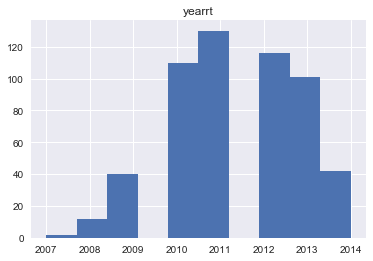

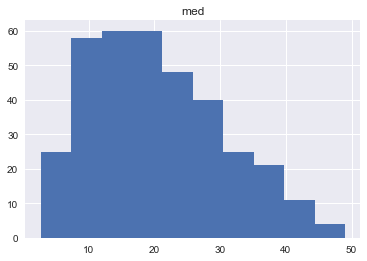

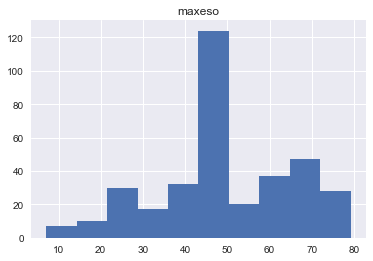

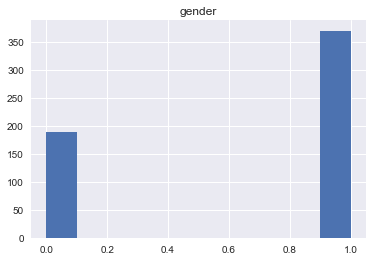

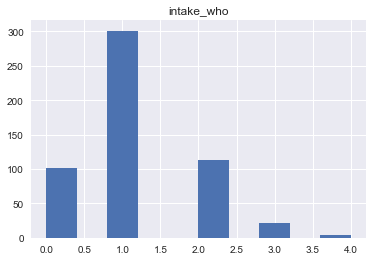

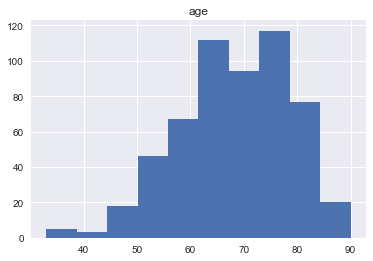

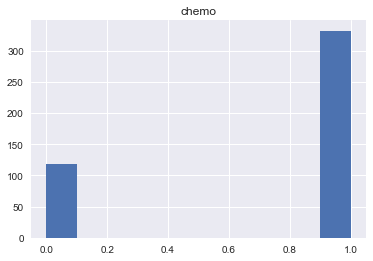

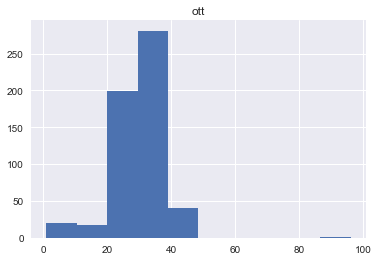

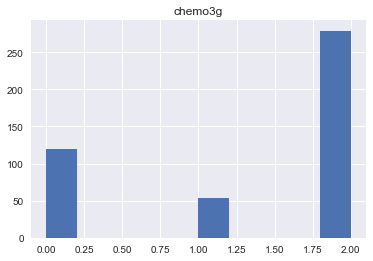

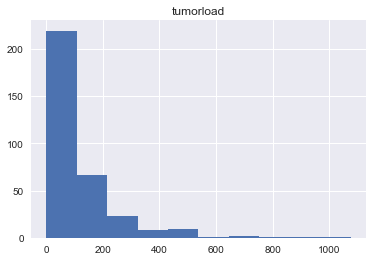

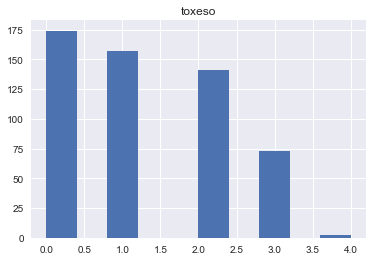

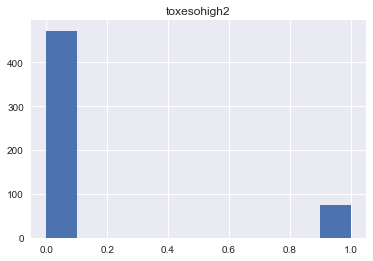

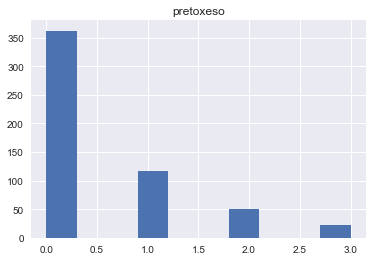

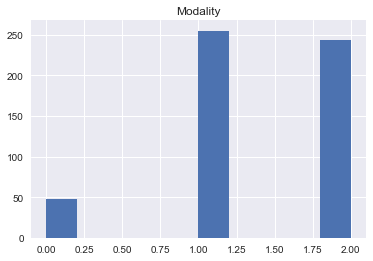

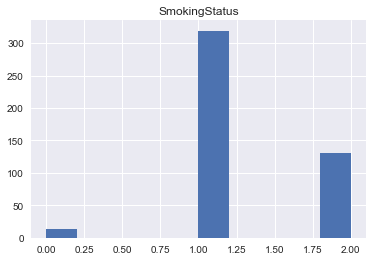

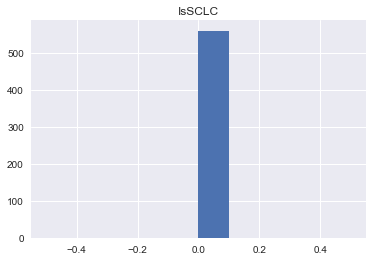

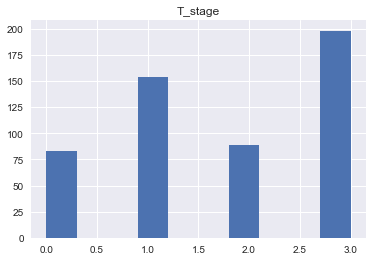

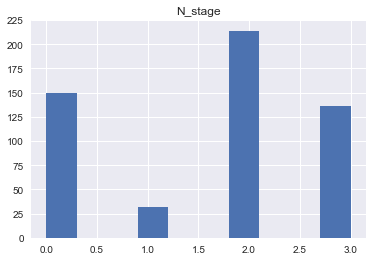

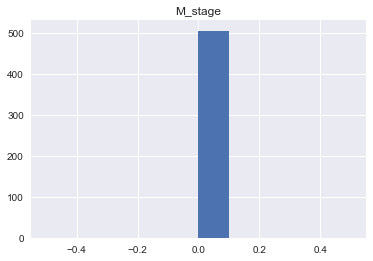

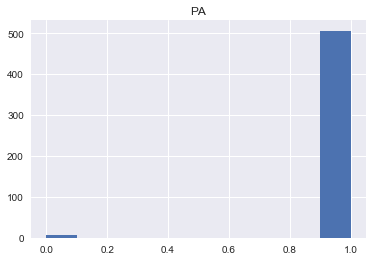

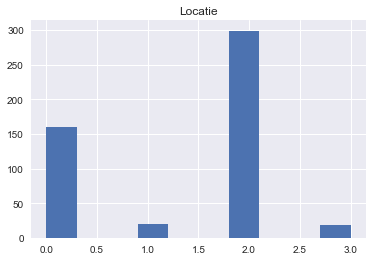

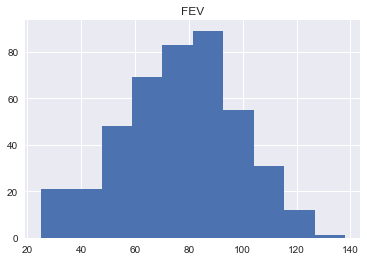

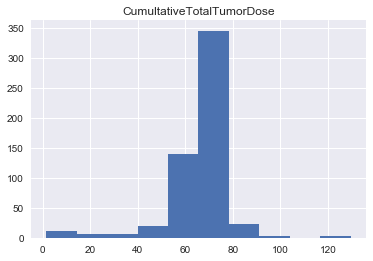

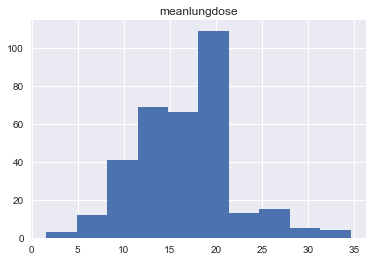

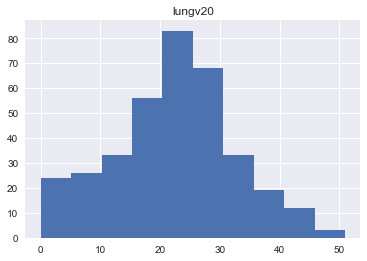

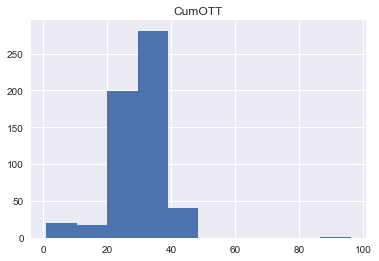

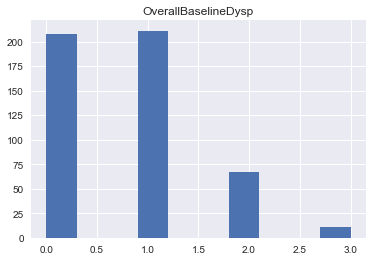

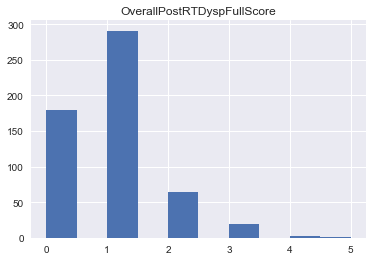

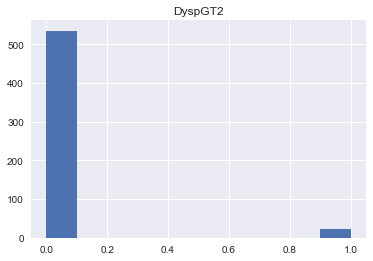

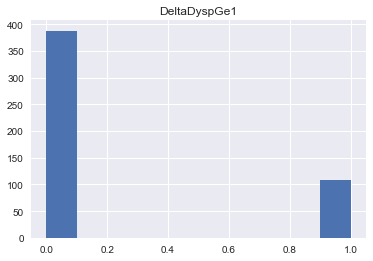

In [8]:
input = df.drop(['TwoYearSurvival'], axis=1)

for column in input:
    plt.hist(input[column].dropna())
    plt.title(column)
    plt.show()

There are more patients in the more recent years of the study. It is possible that these patients live longer since they are being treated with more state of the art technology, which could skew the data towards survival. But, technology is always improving, and we would likely see the same skew in most longitudinal medical studies. In this study, since all patients are undergoing the standard NSCLC protocol, we may not see that year of treatment has any effect on survival.<br>

There is a relatively normal age distribution, with the majority of patients ranging from 65-75. <br>

More people received chemotherapy than did not receive chemotherapy.<br>

Although the overall treatment time ranges from 1-96 months, there is only one observation at 96 months; the rest of the patients fall under 50 months, which is about 4 years of treatment.<br>

The tumorload has a near exponential decrease, which either means that most patients have a relatively low tumor load, or that those patients fall within the normal range and very few patients have an extreme tumorload that exceeds that range.<br>

The esophageal toxicity (toxeso) histogram shows that zero esophageal toxicity is most common, with high numbers of patients at levels 1 and 2 as well. Few patients have severe toxicity at 3, and only 1 patient has level 4.<br>

The dose per fraction also maxes out at the beginning. From a medical perspective, the lower the dose the better, only the minimum biological effective dose should be used to help prevent side effects and complications. The same trend is seen in second dose per fraction. The number of total fractions given is more varied; it peaks, drops, and rises again. The same trend is seen in total dose.<br>

For people who smoke, the common quantity to consume is 1 pack per day. The next most common quantity is 1/2 pack per day, and shortly behind that is 0 packs (non-smokers).<br>

There is a healthy distribution of values for both T and N classifications, which will help to build a reliable model. There is, however, only 1 value for the M classification, so this feature will likely not make the cut in the final model.<br>

FEV has a near perfect normal distribution, which may make it a good feature to include.<br>

Cumulative total tumor dose has a much more normal distribution than total tumor dose, which makes sense because it has over double the number of observations. The normal distribution might make this another good feature to include.<br>

Lungv20 has a normal distribution as well. This makes intuitive sense because this metric should be targeted to deliver as much medicine to the lungs as possible, but if too much is given the patient will develop pneumonitis. The distribution should therefore be centered around the middle.<br>

More patients tended not to have dyspnea at baseline, with the majority of values falling at 0 or 1. The patients that did have dyspnea likely started with a stronger disease burden, which may correlate to their survival. <br>

The variables with normal distributions are age, FEV, Cumulative Total Tumor Dose, and lungv20. We will keep these in mind when moving forward.

Now I'd like to look at a correlation matrix to see the relationships between variables.

In [9]:
corrmat = df.corr()
print(corrmat['TwoYearSurvival'])
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
corrmat

yearrt                        0.198887
med                           0.124601
maxeso                        0.104804
gender                        0.066701
intake_who                    0.102559
age                           0.067338
chemo                        -0.053787
ott                          -0.180136
chemo3g                      -0.044269
tumorload                     0.177023
toxeso                        0.093582
toxesohigh2                   0.073368
pretoxeso                    -0.032043
Modality                      0.062833
SmokingStatus                -0.037060
IsSCLC                             NaN
T_stage                      -0.009541
N_stage                       0.137334
M_stage                            NaN
PA                            0.024870
Locatie                      -0.039418
FEV                          -0.106958
CumultativeTotalTumorDose    -0.147027
meanlungdose                  0.097729
lungv20                       0.196407
CumOTT                   

,yearrt,med,maxeso,gender,intake_who,age,chemo,ott,chemo3g,tumorload,toxeso,toxesohigh2,pretoxeso,Modality,SmokingStatus,IsSCLC,T_stage,N_stage,M_stage,PA,Locatie,FEV,CumultativeTotalTumorDose,meanlungdose,lungv20,CumOTT,OverallBaselineDysp,OverallPostRTDyspFullScore,DyspGT2,DeltaDyspGe1,TwoYearSurvival
yearrt,1.000000,0.035484,0.170502,0.022171,0.101750,0.092262,-0.132144,-0.074144,-0.124391,0.001419,0.019743,-0.011638,-0.028859,0.785852,-0.032330,NaN,-0.021221,0.009848,NaN,0.024006,-0.038233,-0.099301,0.024296,-0.093961,-0.078641,-0.073638,0.025096,0.083471,-0.000678,-0.061878,0.198887
med,0.035484,1.000000,0.685031,-0.013612,0.127662,0.041787,0.103075,-0.323796,0.015743,0.343370,0.276970,0.176292,0.010657,-0.037155,-0.032434,NaN,0.095781,0.322424,NaN,-0.031029,-0.117122,0.027104,-0.282365,0.452758,0.541446,-0.323505,0.110745,0.043273,0.016402,-0.090430,0.124601
maxeso,0.170502,0.685031,1.000000,0.064168,0.155735,0.150098,-0.060674,-0.259238,-0.205260,0.080694,0.041139,-0.060629,-0.210410,0.118773,0.041726,NaN,0.088251,0.063772,NaN,0.010165,-0.108905,-0.080982,-0.029768,0.256328,0.452165,-0.258884,0.160408,0.032826,0.016594,-0.163323,0.104804
gender,0.022171,-0.013612,0.064168,1.000000,0.052541,0.215333,-0.056850,-0.035446,-0.076631,0.145503,-0.109016,-0.079475,-0.105280,0.042404,0.014501,NaN,0.063357,-0.038292,NaN,0.075692,0.042166,-0.148245,-0.009368,-0.059605,-0.004486,-0.035608,-0.002582,0.034739,-0.016519,0.062249,0.066701
intake_who,0.101750,0.127662,0.155735,0.052541,1.000000,0.160668,-0.204388,-0.052391,-0.233440,0.060034,0.017873,0.037378,-0.040470,0.019391,0.004963,NaN,-0.058642,-0.133962,NaN,0.012925,0.080843,-0.165784,-0.098427,-0.082891,-0.000247,-0.052659,0.435516,0.336889,0.232220,0.005699,0.102559
age,0.092262,0.041787,0.150098,0.215333,0.160668,1.000000,-0.380028,-0.176119,-0.434831,-0.132469,-0.196950,-0.160623,-0.238382,0.091707,-0.201562,NaN,-0.079190,-0.243414,NaN,0.109747,-0.065149,-0.003546,-0.019162,-0.012839,0.183543,-0.176510,0.158830,0.155274,0.112600,-0.001902,0.067338
chemo,-0.132144,0.103075,-0.060674,-0.056850,-0.204388,-0.380028,1.000000,0.212733,0.932458,0.108469,0.311989,0.216224,0.297100,-0.147750,0.000125,NaN,0.309738,0.469623,NaN,-0.051460,0.071722,0.271034,-0.103707,0.166079,-0.045534,0.213209,-0.302601,-0.229349,-0.119252,0.075513,-0.053787
ott,-0.074144,-0.323796,-0.259238,-0.035446,-0.052391,-0.176119,0.212733,1.000000,0.266783,-0.133776,0.193045,0.086609,0.169078,-0.074765,0.060999,NaN,0.004838,-0.002630,NaN,0.126577,0.079917,0.084749,0.613298,0.025968,-0.314085,0.999986,-0.106849,-0.095122,-0.046729,0.043190,-0.180136
chemo3g,-0.124391,0.015743,-0.205260,-0.076631,-0.233440,-0.434831,0.932458,0.266783,1.000000,0.143610,0.339678,0.252552,0.361789,-0.152546,0.000380,NaN,0.252156,0.463517,NaN,-0.066528,0.076412,0.285565,-0.136605,0.163836,-0.138129,0.267231,-0.333993,-0.239390,-0.134257,0.072189,-0.044269
tumorload,0.001419,0.343370,0.080694,0.145503,0.060034,-0.132469,0.108469,-0.133776,0.143610,1.000000,0.062906,0.082007,0.060811,-0.005453,-0.021100,NaN,0.359041,0.118654,NaN,-0.058530,0.100813,0.075595,-0.265619,0.173426,0.120387,-0.133568,0.041443,0.059287,0.016452,-0.026728,0.177023


The strongest covariance with outcome is -0.199, -0.177 for yearrt and tumorload. Yearrt is Year of RT, which means the year of receiving radiation therapy (RT). I would imagine that the higher the year, the more advanced the technology, and the higher the 2-year survival -- however, that is not the case here, as the correlation is negative. Despite being the strongest relationship of the group, -0.199 is not very strong. We should keep in mind that patients are still undergoing standard treatment protocols, some of which were established in 2005. Advancements in medical technology may not be employed here, and the decrease in survival through the years may be attributed to something else such as change in staff. Also, we saw from the histogram that there were more patients enrolled in the later years, which may have had an effect.

# Classification Models

The evaluation measure I have chosen is a combination between precision, recall, and accuracy. The most common cross-validation score is a measure of conventional accuracy. However, conventional accuracy is not the best measure when predicting human lives, since the cost of a wrong prediction is literally a matter of life and death. A prediction of life when the outcome is death would prevent that person and their familiy from being able to adequately prepare themselves for the future, and this should be avoided at all costs.<br>

For this reason, I chose to look at the combination of precision and recall in a custom f-score. Precision is the number of true positives over the number of true positives plus false positives. This means we are considering the number of accurately predicted deaths out of all predicted deaths. Recall is the number of true positives over the number of true positives plus false negatives. This means that we are considering the number of accurately predicted deaths out of all total deaths. <br>

Essentially, precision measures the ability to identify real deaths against false-alarm deaths. The people who slip through the cracks end up living longer than expected. Recall measures the ability to predict death correctly against predicting life incorrectly. The people who slip through the cracks are the ones who die unexpectedly and without a chance to prepare. Since this consequence is more severe, I will choose a scoring measure that places more weight on recall than precision.<br>

However, when only recall and precision are considered, the models aggressively predict death to minimize any possible false negatives. This isn't suitable because as a result, the models lose out on predicting positives. For this reason, we also include the standard cross-validation accuracy score, which is calculated as the mean for each fold. The standard accuracy is a combination of both positive and negative accuracy, positive accuracy being the same as recall. For this reason, I have undervalued recall in the F1 score by choosing a beta value of 0.33. Overall, recall is still the strongest factor considered in the scoring metric, as it is represented twice. The custom F1 score is weighted at 60% of the final scoring metric, and the accuracy is weighted at 40%. This ensures that false negatives are avoided but not at great cost to the true positives.

I have used cross-validation with 5 folds because it is computationally cheap, but creates enough diversity amongst models to protect against overfitting.

Now to convert all the categorical features into dummy features (not including the ordinal features).

In [10]:
categorical = ['gender','Modality','PA','Locatie','DeltaDyspGe1']
df_cat = pd.get_dummies(df, columns = categorical)
df_cat = df_cat.fillna(df_cat.mean())

X = df_cat.loc[:, ~(df_cat.columns).isin(['TwoYearSurvival'])]
Y = df_cat['TwoYearSurvival']

print(df_cat.head())
print(df_cat.shape)

   yearrt        med     maxeso  intake_who  age     chemo  ott   chemo3g  \
0  2010.0  17.034600  44.898900         2.0   67  1.000000   21  2.000000   
1  2014.0  20.334135  49.199991         1.0   69  0.736142   36  1.354767   
2  2010.0  20.334135  49.199991         1.0   82  0.736142   24  1.354767   
3  2013.0  17.229800  48.921700         1.0   77  1.000000   36  2.000000   
4  2013.0  20.334135  49.199991         2.0   83  0.736142   28  1.354767   

    tumorload  toxeso  toxesohigh2  pretoxeso  SmokingStatus  IsSCLC  T_stage  \
0   52.505500     2.0          0.0        2.0       1.252155       0      0.0   
1  114.555789     2.0          0.0        2.0       1.000000       0      3.0   
2  114.555789     1.0          0.0        0.0       1.000000       0      1.0   
3   42.274500     1.0          0.0        1.0       1.000000       0      1.0   
4  114.555789     0.0          0.0        0.0       1.000000       0      1.0   

   N_stage  M_stage        FEV  CumultativeTotalTu

Setting up the scoring function combining F1 Score and accuracy with 5-fold cross validation.

In [11]:
ftwo_scorer = make_scorer(fbeta_score, beta=0.33)

def recall_score(model, X, Y):
    
    scores = cross_validate(model, X, Y, cv = 5, scoring = ftwo_scorer)
    
    train_ = scores['train_score'].mean()
    test_ = scores['test_score'].mean()
    accuracy = cross_val_score(model, X, Y, cv=5).mean()
    score = (.6*test_) + (.4*accuracy)
    
    pred_y = model.predict(X)
    cm = pd.crosstab(Y, pred_y)
    
    # Adding this clause in case model predicts only 1 outcome
    
    if cm.shape != (2,2):
        if cm.columns.values[0] == 1:
            true_neg_p = 0
            true_pos_p = 1
        else:
            true_neg_p = 1
            true_pos_p = 0
    else:    
        true_neg_p = cm[0][0]/(cm[0][0] + cm[1][0])
        true_pos_p = cm[1][1]/(cm[1][1] + cm[0][1])
    
    """
    print(cm)
    print(f'Negative Accuracy: {true_neg_p}')
    print(f'Positive Accuracy: {true_pos_p}')
    print(f'Training Score: {train_}')
    print(f'Testing Score: {test_}')
    print(f'Cross-Val Accuracy: {accuracy}\n')
    print(f'Final Score: {score}\n')
    """
    
    results=({'Final Score':score, 'Training Score':train_, 'Testing Score':test_, 'Cross-Val Accuracy':accuracy,
    'Negative Accuracy':true_neg_p, 'Positive Accuracy':true_pos_p})

    return results

# Lasso Regression

Since there are many features (39 including new dummy features) I will first perform lasso regression with L1 regularization to do an initial round of feature reduction. To account for missing data, I will fill all NaN values with averages for their respective columns. Since there are only 559 observations, it is not practical to drop all observations with NaN values.<br>

Logistic regression is fast and simple, thereby providing a good baseline to compare future models. For lasso regression specifically, I care to see which features were dropped (coefficients reduced to 0).

In [12]:
def run_logistic(X, Y, pen):
    runs = []
    X_scaled = StandardScaler().fit_transform(X)
    
    def log_res(alpha, pen):
        
        lr = LogisticRegression(C = alpha, penalty = pen)
        fit = lr.fit(X_scaled, Y)
        
        print(f'C = {alpha}\n')

        fit.coef_
        coeff = fit.coef_[0]
        
        # Print coefficients
        #for i in range(len(coeff)):
            #print(X.columns.values[i], coeff[i])
        #print(fit.intercept_)
        
        # Problem: the model returns coefficients as an array of 1 array
        # Solution: isolate the first element of that array & map the values to their respective features
        
        co_dict = {'columns': X.columns.values, 'coefficients': coeff}
        ranked_co = pd.DataFrame(data=co_dict)
        ranked_co['abs'] = abs(ranked_co['coefficients'])
        ranked_co = ranked_co.sort('abs', ascending=False)
        print(ranked_co)
        
        results = recall_score(lr, X_scaled, Y)
        results['alpha'] = alpha
        runs.append(results)
        print(results)
    
    alpha_nums = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5, 1e7, 1e9]

    for alpha in alpha_nums:
        log_res(alpha, pen)
        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
            
run_logistic(X,Y,'l1')

C = 0.0001

    coefficients                     columns  abs
0            0.0                      yearrt  0.0
28           0.0                Modality_1.0  0.0
21           0.0                      CumOTT  0.0
22           0.0         OverallBaselineDysp  0.0
23           0.0  OverallPostRTDyspFullScore  0.0
24           0.0                     DyspGT2  0.0
25           0.0                    gender_0  0.0
26           0.0                    gender_1  0.0
27           0.0                Modality_0.0  0.0
29           0.0                Modality_2.0  0.0
1            0.0                         med  0.0
30           0.0                      PA_0.0  0.0
31           0.0                      PA_1.0  0.0
32           0.0                 Locatie_0.0  0.0
33           0.0                 Locatie_1.0  0.0
34           0.0                 Locatie_2.0  0.0
35           0.0                 Locatie_3.0  0.0
36           0.0            DeltaDyspGe1_0.0  0.0
20           0.0                     l

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pred

{'Final Score': 0.15742599742599742, 'Training Score': 0.0, 'Testing Score': 0.0, 'Cross-Val Accuracy': 0.39356499356499353, 'Negative Accuracy': 1, 'Positive Accuracy': 0, 'alpha': 0.01}
C = 0.1

    coefficients                     columns       abs
0       0.354741                      yearrt  0.354741
6      -0.211607                         ott  0.211607
15      0.172076                     N_stage  0.172076
20      0.170515                     lungv20  0.170515
8       0.160652                   tumorload  0.160652
17     -0.118675                         FEV  0.118675
33      0.110605                 Locatie_1.0  0.110605
24      0.100096                     DyspGT2  0.100096
37      0.085865            DeltaDyspGe1_1.0  0.085865
9       0.076787                      toxeso  0.076787
31      0.054329                      PA_1.0  0.054329
18     -0.049081   CumultativeTotalTumorDose  0.049081
29     -0.045371                Modality_2.0  0.045371
3       0.038118                 

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63609455452382013, 'Training Score': 0.72954391721047396, 'Testing Score': 0.66654969726513991, 'Cross-Val Accuracy': 0.59041184041184047, 'Negative Accuracy': 0.45909090909090911, 'Positive Accuracy': 0.82595870206489674, 'alpha': 0.3}
C = 0.5

    coefficients                     columns       abs
0       0.687495                      yearrt  0.687495
27      0.346107                Modality_0.0  0.346107
8       0.316914                   tumorload  0.316914
6      -0.313298                         ott  0.313298
15      0.312594                     N_stage  0.312594
28      0.308182                Modality_1.0  0.308182
1      -0.298147                         med  0.298147
20      0.296429                     lungv20  0.296429
37      0.229241            DeltaDyspGe1_1.0  0.229241
9       0.217773                      toxeso  0.217773
24      0.202678                     DyspGT2  0.202678
17     -0.201078                         FEV  0.201078
31      0.187864     

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63810198255014916, 'Training Score': 0.73418555818820253, 'Testing Score': 0.66869420944115388, 'Cross-Val Accuracy': 0.59221364221364214, 'Negative Accuracy': 0.48181818181818181, 'Positive Accuracy': 0.81710914454277284, 'alpha': 0.5}
C = 1

    coefficients                     columns       abs
0       0.721631                      yearrt  0.721631
27      0.413714                Modality_0.0  0.413714
1      -0.375049                         med  0.375049
6      -0.358106                         ott  0.358106
5      -0.355954                       chemo  0.355954
28      0.343011                Modality_1.0  0.343011
8       0.340401                   tumorload  0.340401
15      0.338069                     N_stage  0.338069
20      0.312063                     lungv20  0.312063
37      0.292935            DeltaDyspGe1_1.0  0.292935
9       0.237711                      toxeso  0.237711
7       0.226246                     chemo3g  0.226246
24      0.221996       

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63661173324066844, 'Training Score': 0.74150838519032169, 'Testing Score': 0.66860213798369661, 'Cross-Val Accuracy': 0.58862612612612608, 'Negative Accuracy': 0.48636363636363639, 'Positive Accuracy': 0.82005899705014751, 'alpha': 1}
C = 100

    coefficients                     columns       abs
0       0.752922                      yearrt  0.752922
27      0.541748                Modality_0.0  0.541748
5      -0.539989                       chemo  0.539989
28      0.468487                Modality_1.0  0.468487
1      -0.454654                         med  0.454654
7       0.417596                     chemo3g  0.417596
6      -0.403073                         ott  0.403073
37      0.377387            DeltaDyspGe1_1.0  0.377387
8       0.363995                   tumorload  0.363995
15      0.363097                     N_stage  0.363097
20      0.333220                     lungv20  0.333220
36      0.267795            DeltaDyspGe1_0.0  0.267795
9       0.262352       

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63685328826523102, 'Training Score': 0.74460148952131544, 'Testing Score': 0.66782497851154976, 'Cross-Val Accuracy': 0.59039575289575286, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100}
C = 1000

    coefficients                     columns       abs
0       0.753129                      yearrt  0.753129
27      0.543684                Modality_0.0  0.543684
5      -0.541811                       chemo  0.541811
28      0.470897                Modality_1.0  0.470897
1      -0.455367                         med  0.455367
7       0.419449                     chemo3g  0.419449
6      -0.410500                         ott  0.410500
37      0.378394            DeltaDyspGe1_1.0  0.378394
8       0.364198                   tumorload  0.364198
15      0.363300                     N_stage  0.363300
20      0.333489                     lungv20  0.333489
36      0.268848            DeltaDyspGe1_0.0  0.268848
9       0.262610    

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63418271581997621, 'Training Score': 0.74504346333840943, 'Testing Score': 0.66456450062660133, 'Cross-Val Accuracy': 0.58861003861003858, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 1000}
C = 100000.0

    coefficients                     columns       abs
0       0.753222                      yearrt  0.753222
27      0.544095                Modality_0.0  0.544095
5      -0.541869                       chemo  0.541869
28      0.471193                Modality_1.0  0.471193
1      -0.455387                         med  0.455387
7       0.419498                     chemo3g  0.419498
37      0.378786            DeltaDyspGe1_1.0  0.378786
8       0.364235                   tumorload  0.364235
15      0.363352                     N_stage  0.363352
20      0.333505                     lungv20  0.333505
36      0.269326            DeltaDyspGe1_0.0  0.269326
9       0.262499                      toxeso  0.262499
17     -0.24086

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63346199509925549, 'Training Score': 0.74504346333840943, 'Testing Score': 0.66456450062660133, 'Cross-Val Accuracy': 0.58680823680823679, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100000.0}
C = 10000000.0

    coefficients                     columns       abs
0       0.753133                      yearrt  0.753133
27      0.543888                Modality_0.0  0.543888
5      -0.541950                       chemo  0.541950
28      0.471139                Modality_1.0  0.471139
1      -0.455361                         med  0.455361
7       0.419511                     chemo3g  0.419511
6      -0.393304                         ott  0.393304
37      0.378521            DeltaDyspGe1_1.0  0.378521
8       0.364214                   tumorload  0.364214
15      0.363304                     N_stage  0.363304
20      0.333523                     lungv20  0.333523
36      0.268984            DeltaDyspGe1_0.0  0.268984
9       0

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63418271581997621, 'Training Score': 0.74482516360767137, 'Testing Score': 0.66456450062660133, 'Cross-Val Accuracy': 0.58861003861003858, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 10000000.0}
C = 1000000000.0

    coefficients                     columns       abs
0       0.753226                      yearrt  0.753226
27      0.544104                Modality_0.0  0.544104
5      -0.541897                       chemo  0.541897
28      0.471214                Modality_1.0  0.471214
1      -0.455390                         med  0.455390
7       0.419538                     chemo3g  0.419538
37      0.378779            DeltaDyspGe1_1.0  0.378779
8       0.364225                   tumorload  0.364225
15      0.363350                     N_stage  0.363350
20      0.333495                     lungv20  0.333495
36      0.269320            DeltaDyspGe1_0.0  0.269320
9       0.262516                      toxeso  0.262516
17   

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63347445193068097, 'Training Score': 0.74482516360767137, 'Testing Score': 0.66338406081110934, 'Cross-Val Accuracy': 0.58861003861003858, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 1000000000.0}
Best Run: {'Final Score': 0.63810198255014916, 'Training Score': 0.73418555818820253, 'Testing Score': 0.66869420944115388, 'Cross-Val Accuracy': 0.59221364221364214, 'Negative Accuracy': 0.48181818181818181, 'Positive Accuracy': 0.81710914454277284, 'alpha': 0.5}


When the regularization coefficient is too low, the model eliminates features very aggressively and ends up predicting life for every patient. This gives the model good negative accuracy, but horrible positive accuracy.<br>

The most commonly used feature is **year of treatment**, with **tumorload** next. I wouldn't have expected the year of treatment to be more important than direct medical indicators, but it was also one of the features that revealed strong covariance with the outcome in the correlation matrix. The next features that get included in the models are **age** and **overall treatment time**, which have a positive and negative correlation with the outcome, respectively.<br>

When regularization is not used (C=1000), we see a smaller gap between negative and positive accuracy. The closest we can get is 50% negative accuracy and 82% positive accuracy. With the scoring metric I've chosen, the best model has a F1 score of 67%, with positive and negative accuracies of 48% and 82%. This model also has a training score of 73%, which means it is slightly overfitting the data. The regularization parameter is set to 0.5, which means regularization is employed but not aggressively. The model eliminated 9 features, many of which were dummy categories.<br><br>
**FINAL SCORE: 63.35%.**

# Ridge Regression

In [13]:
run_logistic(X,Y, 'l2')

C = 0.0001

    coefficients                     columns       abs
0       0.005279                      yearrt  0.005279
6      -0.004693                         ott  0.004693
21     -0.004686                      CumOTT  0.004686
20      0.004163                     lungv20  0.004163
18     -0.003846   CumultativeTotalTumorDose  0.003846
8       0.003649                   tumorload  0.003649
15      0.003587                     N_stage  0.003587
23      0.003342  OverallPostRTDyspFullScore  0.003342
3       0.002634                  intake_who  0.002634
24      0.002592                     DyspGT2  0.002592
33      0.002564                 Locatie_1.0  0.002564
1       0.002533                         med  0.002533
17     -0.002496                         FEV  0.002496
9       0.002492                      toxeso  0.002492
37      0.002457            DeltaDyspGe1_1.0  0.002457
2       0.002142                      maxeso  0.002142
19      0.002000                meanlungdose  0.00200

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.63655892694613148, 'Training Score': 0.73633842109815717, 'Testing Score': 0.66614390012257441, 'Cross-Val Accuracy': 0.59218146718146714, 'Negative Accuracy': 0.50454545454545452, 'Positive Accuracy': 0.81710914454277284, 'alpha': 0.1}
C = 0.3

    coefficients                     columns       abs
0       0.669834                      yearrt  0.669834
1      -0.382715                         med  0.382715
27      0.377956                Modality_0.0  0.377956
5      -0.357438                       chemo  0.357438
15      0.338382                     N_stage  0.338382
8       0.335523                   tumorload  0.335523
20      0.299333                     lungv20  0.299333
37      0.294038            DeltaDyspGe1_1.0  0.294038
28      0.274513                Modality_1.0  0.274513
9       0.237392                      toxeso  0.237392
7       0.236655                     chemo3g  0.236655
17     -0.227495                         FEV  0.227495
24      0.215587     

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.6369470491489595, 'Training Score': 0.74194357751764273, 'Testing Score': 0.6703729240427746, 'Cross-Val Accuracy': 0.58680823680823679, 'Negative Accuracy': 0.50454545454545452, 'Positive Accuracy': 0.81415929203539827, 'alpha': 0.5}
C = 1

    coefficients                     columns       abs
0       0.724774                      yearrt  0.724774
27      0.475074                Modality_0.0  0.475074
5      -0.466595                       chemo  0.466595
1      -0.430661                         med  0.430661
28      0.385506                Modality_1.0  0.385506
8       0.355338                   tumorload  0.355338
15      0.355077                     N_stage  0.355077
7       0.344230                     chemo3g  0.344230
37      0.343492            DeltaDyspGe1_1.0  0.343492
20      0.321007                     lungv20  0.321007
9       0.253854                      toxeso  0.253854
36      0.245011            DeltaDyspGe1_0.0  0.245011
17     -0.236639         

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.6357162387229327, 'Training Score': 0.74460148952131544, 'Testing Score': 0.66592989594105256, 'Cross-Val Accuracy': 0.59039575289575286, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100}
C = 1000

    coefficients                     columns       abs
6      -5.568090                         ott  5.568090
21      5.164856                      CumOTT  5.164856
0       0.751559                      yearrt  0.751559
5      -0.542544                       chemo  0.542544
27      0.540166                Modality_0.0  0.540166
28      0.470418                Modality_1.0  0.470418
1      -0.455348                         med  0.455348
7       0.418748                     chemo3g  0.418748
37      0.373648            DeltaDyspGe1_1.0  0.373648
8       0.363937                   tumorload  0.363937
15      0.362717                     N_stage  0.362717
20      0.333824                     lungv20  0.333824
9       0.264136     

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.62986646323671325, 'Training Score': 0.74526713742476536, 'Testing Score': 0.65976242371284033, 'Cross-Val Accuracy': 0.58502252252252251, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 1000}
C = 100000.0

    coefficients                     columns        abs
6     -16.540927                         ott  16.540927
21     16.137257                      CumOTT  16.137257
0       0.750111                      yearrt   0.750111
5      -0.543237                       chemo   0.543237
27      0.536734                Modality_0.0   0.536734
28      0.469918                Modality_1.0   0.469918
1      -0.455341                         med   0.455341
7       0.418069                     chemo3g   0.418069
37      0.369038            DeltaDyspGe1_1.0   0.369038
8       0.363680                   tumorload   0.363680
15      0.362145                     N_stage   0.362145
20      0.334164                     lungv20   0.334164
9 

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.62986646323671325, 'Training Score': 0.74525906615864823, 'Testing Score': 0.65976242371284033, 'Cross-Val Accuracy': 0.58502252252252251, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100000.0}
C = 10000000.0

    coefficients                     columns        abs
6     -27.571378                         ott  27.571378
21     27.167055                      CumOTT  27.167055
0       0.749675                      yearrt   0.749675
5      -0.543576                       chemo   0.543576
27      0.535692                Modality_0.0   0.535692
28      0.469707                Modality_1.0   0.469707
1      -0.455327                         med   0.455327
7       0.418029                     chemo3g   0.418029
37      0.367692            DeltaDyspGe1_1.0   0.367692
8       0.363592                   tumorload   0.363592
15      0.361987                     N_stage   0.361987
20      0.334264                     lungv20   0.334

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.62986646323671325, 'Training Score': 0.74503144624434781, 'Testing Score': 0.65976242371284033, 'Cross-Val Accuracy': 0.58502252252252251, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 10000000.0}
C = 1000000000.0

    coefficients                     columns        abs
6     -24.339896                         ott  24.339896
21     23.935788                      CumOTT  23.935788
0       0.749731                      yearrt   0.749731
5      -0.543521                       chemo   0.543521
27      0.535962                Modality_0.0   0.535962
28      0.469849                Modality_1.0   0.469849
1      -0.455322                         med   0.455322
7       0.418034                     chemo3g   0.418034
37      0.368002            DeltaDyspGe1_1.0   0.368002
8       0.363608                   tumorload   0.363608
15      0.362017                     N_stage   0.362017
20      0.334232                     lungv20   0

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.62986646323671325, 'Training Score': 0.7454814191561262, 'Testing Score': 0.65976242371284033, 'Cross-Val Accuracy': 0.58502252252252251, 'Negative Accuracy': 0.50909090909090904, 'Positive Accuracy': 0.81710914454277284, 'alpha': 1000000000.0}
Best Run: {'Final Score': 0.64626750098050478, 'Training Score': 0.72276496968852155, 'Testing Score': 0.68109148061315372, 'Cross-Val Accuracy': 0.59403153153153154, 'Negative Accuracy': 0.58636363636363631, 'Positive Accuracy': 0.68731563421828912, 'alpha': 0.0001}


Using ridge regression, we were able to obtain very similar results to lasso regression. Again, the models did better with moderate regularization, and the best model had lambda = 0.5. This means large parameter estimates were not penalized aggressively. With a negative accuracy of 58.64%, positive accuracy of 68.73%, and testing score of 68.11%, ridge regression performed slightly better than the lasso model.<br><br>

**FINAL SCORE: 64.63%**

# Decision Tree

In [14]:
def run_tree(X,Y):
    runs = []

    def decision_tree (depth_max, random, feature_max, min_split):
        decision_tree = tree.DecisionTreeClassifier(
            criterion = 'entropy',
            max_depth = depth_max,
            random_state = random,
            max_features = feature_max,
            min_samples_split = min_split
        )
        decision_tree.fit(X, Y)

        dot_data = tree.export_graphviz(
            decision_tree, out_file=None,
            feature_names=X.columns.values,
            class_names=['die','live'],
            filled=True
        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graphimage = Image(graph.create_png())
        #display(graphimage)

        print(f'Max Depth: {depth_max}, Random State = {random}, Max Feature = {feature_max}, Min Samples Split = {min_split}')
        results = recall_score(decision_tree, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        results['Max Feature'] = feature_max
        results['Min Samples Split'] = min_split
        runs.append(results)
        print(results)
        print("\n")
        
    depth_maxs = [3,4,5]
    randoms = [1]
    feature_maxs = [4,5,6,7]
    min_splits = [4,5,6,7]

    for depth_max in depth_maxs:
        for random in randoms:
            for feature_max in feature_maxs:
                for min_split in min_splits:
                    decision_tree (depth_max, random, feature_max, min_split)
                    
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    
run_tree(X,Y)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
{'Final Score': 0.62049830138297901, 'Training Score': 0.68347227025597745, 'Testing Score': 0.6381428146172774, 'Cross-Val Accuracy': 0.59403153153153154, 'Negative Accuracy': 0.26363636363636361, 'Positive Accuracy': 0.91445427728613571, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 4}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
{'Final Score': 0.62049830138297901, 'Training Score': 0.68347227025597745, 'Testing Score': 0.6381428146172774, 'Cross-Val Accuracy': 0.59403153153153154, 'Negative Accuracy': 0.26363636363636361, 'Positive Accuracy': 0.91445427728613571, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 5}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
{'Final Score': 0.62049830138297901, 'Training Score': 0.68347227025597745, 'Testing Score': 0.6381428146172774, 'Cross-Val Accuracy': 0.594031531531

The highest cross-val score achieved through a decision tree is 63.56% using parameters Max Depth = 5, Random State = 1, Max Features = 6, Min Samples Split = 7. This is slightly worse than the scores achieved through logistic regression using ridge and lasso methods. The difference between the training and testing F1 score is only 3.5%, which means overfitting is not an issue here. Negative accuracy is at 33.18%, which is significantly lower than the values we were seeing with logistic regression. Positive accuracy is at 85.6%, which is fairly decent for this critical measure.
**FINAL SCORE: 63.56%**


# Random Forest

In [15]:
from sklearn import ensemble

def run_forest(X,Y):
    runs = []

    def random_forest(depth_max, feature_max, min_split, n, random):
        rfc = ensemble.RandomForestClassifier(
            max_depth = depth_max,
            max_features = feature_max,
            min_samples_split = min_split,
            n_estimators = n,
            random_state = random
            )

        rfc.fit(X,Y)

        print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Number of Trees = {n}, Random State = {random}, Min Samples Split: {min_split}')

        results = recall_score (rfc, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        results['Max Feature'] = feature_max
        results['Number of Trees'] = n
        results['Min Samples Split'] = min_split
        runs.append(results)
        print(results)
        print("\n")
        
    depth_maxs = [3,4,5]
    randoms = [1]
    feature_maxs = [4,5,6,7]
    min_splits = [4,5,6,7]
    ns = [10, 50, 100]

    for depth_max in depth_maxs:
        for feature_max in feature_maxs:
            for min_split in min_splits:
                for n in ns:
                    for random in randoms:
                        random_forest (depth_max, feature_max, min_split, n, random)
                        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    
run_forest(X,Y)

Max Depth: 3, Max Feature = 4, Number of Trees = 10, Random State = 1, Min Samples Split: 4
{'Final Score': 0.62283865694727469, 'Training Score': 0.69566584143695898, 'Testing Score': 0.6384719786530082, 'Cross-Val Accuracy': 0.59938867438867438, 'Negative Accuracy': 0.2818181818181818, 'Positive Accuracy': 0.92035398230088494, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 10, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 50, Random State = 1, Min Samples Split: 4
{'Final Score': 0.61347024079155232, 'Training Score': 0.68139763083333049, 'Testing Score': 0.62886395773281023, 'Cross-Val Accuracy': 0.59037966537966535, 'Negative Accuracy': 0.18636363636363637, 'Positive Accuracy': 0.98820058997050142, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 50, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 100, Random State = 1, Min Samples Split: 4
{'Final Score': 0.61914242767915051, 'T

The highest score using random forest is 64.13%. This was achieved using Max Depth = 4, Random State = 1, Max Features = 7, Min Samples Split = 5, and Number of Trees = 10. The score generally goes down as we use more features, and up as we increase the number of trees in the forest. The score is slightly higher than that of the best singular decision tree, which was 63.56, but this is not a significant difference. As expected, it took a long time to run.<br><br>

**FINAL SCORE: 64.13%**


# Support Vector Machines

In [16]:
from sklearn.svm import SVC

def run_svc(X,Y):

    runs = []
    def svc(alpha, kern, gam):
        svc = SVC(C=alpha, kernel=kern, gamma=gam)
        svc.fit(X,Y)
        print(f'Kernel: {kern}')
        print(f'C = {alpha}')
        print(f'Gamma = {gam}')

        results = recall_score(svc, X, Y)
        results['alpha'] = alpha
        results['kernel type'] = kern
        results['gamma'] = gam
        runs.append(results)

    kernels = ['linear', 'rbf']
    alpha_nums = [1e-7, 1e-3, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5]
    gamma = [1e-7, 1e-3, 0.1, 0.3, 0.5, 1]

    for kern in kernels:
        for alpha in alpha_nums:
            for gam in gamma:
                if kern == 'linear':
                    svc(alpha, kern, 1/35)
                else:
                    svc(alpha, kern, gam)
            
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
            
run_svc(X,Y)

Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.3
Gamma = 0.02857142857142857
Kernel:

The best SVM model uses a lambda of 1e5 and a radial kernel to achieve a combined score of 66.9%. So far, this is the best score. This score is made up of 48.18% negative accuracy, 84.07% positive accuracy, testing score of 69.05%, and training score of 72.64%. Overfitting is very minimal.<br><br>
**FINAL SCORE: 66.9%**


# Boosting Models

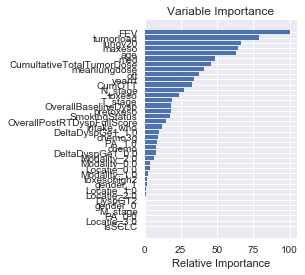

{'Final Score': 0.59856248886981012, 'Training Score': 0.8170083255453946, 'Testing Score': 0.62661530212750427, 'Cross-Val Accuracy': 0.55648326898326894, 'Negative Accuracy': 0.67272727272727273, 'Positive Accuracy': 0.84365781710914456, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['IsSCLC', 'Locatie_3.0', 'PA_0.0', 'M_stage', 'gender_0', 'DyspGT2', 'Locatie_2.0', 'Locatie_1.0', 'gender_1', 'toxesohigh2', 'Modality_1.0', 'Locatie_0.0', 'Modality_0.0', 'Modality_2.0', 'DeltaDyspGe1_0.0', 'chemo', 'PA_1.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'intake_who', 'OverallPostRTDyspFullScore', 'SmokingStatus', 'pretoxeso', 'OverallBaselineDysp', 'T_stage', 'toxeso', 'N_stage', 'CumOTT', 'yearrt', 'ott', 'meanlungdose', 'CumultativeTotalTumorDose', 'med', 'age', 'maxeso', 'lungv20', 'tumorload', 'FEV']}




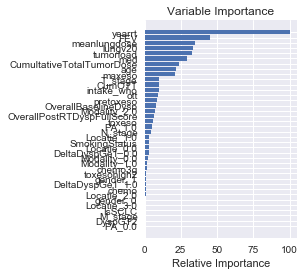

{'Final Score': 0.58940373536366775, 'Training Score': 0.5811973393296459, 'Testing Score': 0.62701995361984086, 'Cross-Val Accuracy': 0.53297940797940802, 'Negative Accuracy': 0.59999999999999998, 'Positive Accuracy': 0.40707964601769914, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['PA_0.0', 'DyspGT2', 'M_stage', 'IsSCLC', 'Locatie_3.0', 'gender_0', 'Locatie_2.0', 'chemo', 'DeltaDyspGe1_1.0', 'gender_1', 'toxesohigh2', 'chemo3g', 'Modality_1.0', 'Modality_0.0', 'DeltaDyspGe1_0.0', 'Locatie_0.0', 'SmokingStatus', 'Locatie_1.0', 'N_stage', 'PA_1.0', 'toxeso', 'OverallPostRTDyspFullScore', 'Modality_2.0', 'OverallBaselineDysp', 'pretoxeso', 'ott', 'intake_who', 'CumOTT', 'T_stage', 'maxeso', 'age', 'CumultativeTotalTumorDose', 'med', 'tumorload', 'lungv20', 'meanlungdose', 'FEV', 'yearrt']}




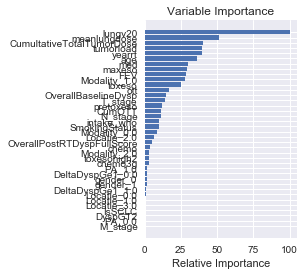

{'Final Score': 0.61188243660109576, 'Training Score': 0.627245360317086, 'Testing Score': 0.6439782351760005, 'Cross-Val Accuracy': 0.5637387387387387, 'Negative Accuracy': 0.54545454545454541, 'Positive Accuracy': 0.46312684365781709, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['M_stage', 'PA_0.0', 'DyspGT2', 'IsSCLC', 'Locatie_3.0', 'Locatie_1.0', 'Locatie_0.0', 'DeltaDyspGe1_1.0', 'gender_1', 'gender_0', 'DeltaDyspGe1_0.0', 'PA_1.0', 'chemo3g', 'toxesohigh2', 'Modality_2.0', 'chemo', 'OverallPostRTDyspFullScore', 'Locatie_2.0', 'Modality_0.0', 'SmokingStatus', 'intake_who', 'N_stage', 'CumOTT', 'pretoxeso', 'T_stage', 'OverallBaselineDysp', 'ott', 'toxeso', 'Modality_1.0', 'FEV', 'maxeso', 'med', 'age', 'yearrt', 'tumorload', 'CumultativeTotalTumorDose', 'meanlungdose', 'lungv20']}




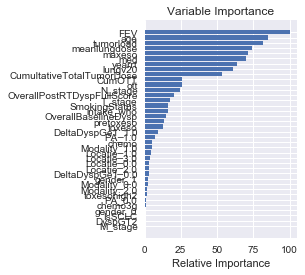

{'Final Score': 0.5791220713706513, 'Training Score': 0.94220579413399685, 'Testing Score': 0.60730984439081082, 'Cross-Val Accuracy': 0.53684041184041187, 'Negative Accuracy': 0.84999999999999998, 'Positive Accuracy': 0.97050147492625372, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'DyspGT2', 'IsSCLC', 'gender_0', 'chemo3g', 'PA_0.0', 'toxesohigh2', 'Modality_2.0', 'Modality_0.0', 'gender_1', 'DeltaDyspGe1_0.0', 'Locatie_2.0', 'Locatie_0.0', 'Locatie_3.0', 'Locatie_1.0', 'Modality_1.0', 'chemo', 'PA_1.0', 'DeltaDyspGe1_1.0', 'toxeso', 'pretoxeso', 'OverallBaselineDysp', 'intake_who', 'SmokingStatus', 'T_stage', 'OverallPostRTDyspFullScore', 'N_stage', 'ott', 'CumOTT', 'CumultativeTotalTumorDose', 'lungv20', 'yearrt', 'med', 'maxeso', 'meanlungdose', 'tumorload', 'age', 'FEV']}




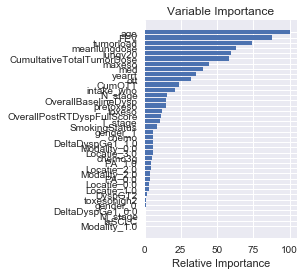

{'Final Score': 0.61499072682231737, 'Training Score': 0.97531169623063507, 'Testing Score': 0.63972070944002712, 'Cross-Val Accuracy': 0.5778957528957529, 'Negative Accuracy': 0.98636363636363633, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['Modality_1.0', 'IsSCLC', 'M_stage', 'DeltaDyspGe1_0.0', 'gender_0', 'toxesohigh2', 'DyspGT2', 'Locatie_1.0', 'Locatie_0.0', 'PA_0.0', 'Modality_2.0', 'Locatie_2.0', 'PA_1.0', 'chemo3g', 'Locatie_3.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'chemo', 'gender_1', 'SmokingStatus', 'T_stage', 'OverallPostRTDyspFullScore', 'toxeso', 'pretoxeso', 'OverallBaselineDysp', 'N_stage', 'intake_who', 'CumOTT', 'ott', 'yearrt', 'med', 'maxeso', 'CumultativeTotalTumorDose', 'lungv20', 'meanlungdose', 'tumorload', 'FEV', 'age']}




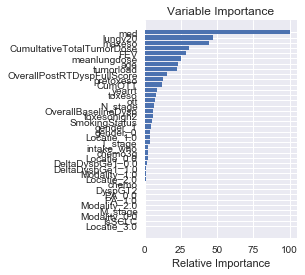

{'Final Score': 0.52491525256321814, 'Training Score': 0.72905398718585368, 'Testing Score': 0.56351169292496883, 'Cross-Val Accuracy': 0.46702059202059204, 'Negative Accuracy': 0.66818181818181821, 'Positive Accuracy': 0.57817109144542778, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['Locatie_3.0', 'IsSCLC', 'Modality_0.0', 'M_stage', 'Modality_2.0', 'PA_1.0', 'PA_0.0', 'DyspGT2', 'chemo', 'Locatie_2.0', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'DeltaDyspGe1_0.0', 'Locatie_0.0', 'chemo3g', 'intake_who', 'T_stage', 'Locatie_1.0', 'gender_0', 'gender_1', 'SmokingStatus', 'toxesohigh2', 'OverallBaselineDysp', 'N_stage', 'ott', 'toxeso', 'yearrt', 'CumOTT', 'pretoxeso', 'OverallPostRTDyspFullScore', 'tumorload', 'age', 'meanlungdose', 'FEV', 'CumultativeTotalTumorDose', 'maxeso', 'lungv20', 'med']}




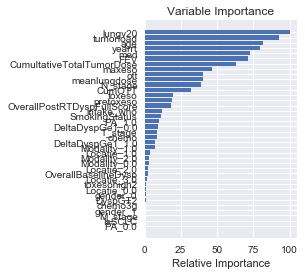

{'Final Score': 0.55261526897243451, 'Training Score': 0.93660814989735619, 'Testing Score': 0.58333776059970321, 'Cross-Val Accuracy': 0.50653153153153152, 'Negative Accuracy': 0.83636363636363631, 'Positive Accuracy': 0.97640117994100295, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['PA_0.0', 'IsSCLC', 'M_stage', 'gender_1', 'chemo3g', 'DyspGT2', 'gender_0', 'Locatie_0.0', 'toxesohigh2', 'Locatie_3.0', 'OverallBaselineDysp', 'Locatie_2.0', 'Modality_0.0', 'Modality_2.0', 'Locatie_1.0', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'chemo', 'T_stage', 'DeltaDyspGe1_0.0', 'PA_1.0', 'SmokingStatus', 'intake_who', 'OverallPostRTDyspFullScore', 'pretoxeso', 'toxeso', 'CumOTT', 'N_stage', 'meanlungdose', 'ott', 'maxeso', 'CumultativeTotalTumorDose', 'FEV', 'med', 'yearrt', 'age', 'tumorload', 'lungv20']}




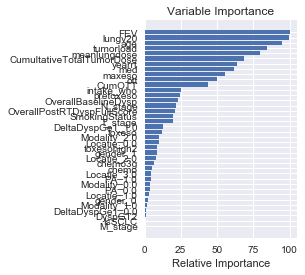

{'Final Score': 0.57534485157994963, 'Training Score': 1.0, 'Testing Score': 0.60458590664440348, 'Cross-Val Accuracy': 0.53148326898326892, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'DeltaDyspGe1_0.0', 'Modality_1.0', 'gender_0', 'Locatie_1.0', 'PA_0.0', 'Modality_0.0', 'PA_1.0', 'Locatie_3.0', 'chemo', 'chemo3g', 'Locatie_2.0', 'gender_1', 'toxesohigh2', 'Locatie_0.0', 'Modality_2.0', 'toxeso', 'DeltaDyspGe1_1.0', 'T_stage', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'N_stage', 'OverallBaselineDysp', 'pretoxeso', 'intake_who', 'CumOTT', 'ott', 'maxeso', 'med', 'yearrt', 'CumultativeTotalTumorDose', 'meanlungdose', 'tumorload', 'age', 'lungv20', 'FEV']}




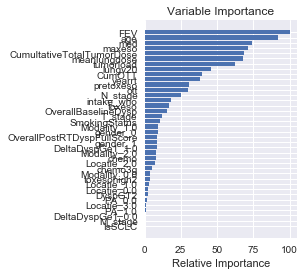

{'Final Score': 0.57276354389964834, 'Training Score': 1.0, 'Testing Score': 0.60266467955818703, 'Cross-Val Accuracy': 0.52791184041184036, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['IsSCLC', 'M_stage', 'DeltaDyspGe1_0.0', 'PA_1.0', 'Locatie_3.0', 'PA_0.0', 'DyspGT2', 'Locatie_0.0', 'Locatie_1.0', 'toxesohigh2', 'Modality_0.0', 'chemo3g', 'Locatie_2.0', 'chemo', 'Modality_2.0', 'DeltaDyspGe1_1.0', 'gender_1', 'OverallPostRTDyspFullScore', 'gender_0', 'Modality_1.0', 'SmokingStatus', 'T_stage', 'OverallBaselineDysp', 'toxeso', 'intake_who', 'N_stage', 'ott', 'pretoxeso', 'yearrt', 'CumOTT', 'lungv20', 'tumorload', 'meanlungdose', 'CumultativeTotalTumorDose', 'maxeso', 'med', 'age', 'FEV']}




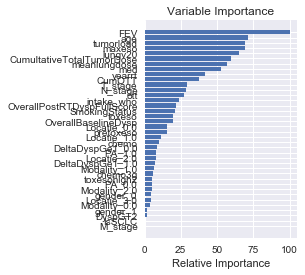

{'Final Score': 0.58886702245883737, 'Training Score': 0.81179999575471817, 'Testing Score': 0.62009797608433426, 'Cross-Val Accuracy': 0.54202059202059205, 'Negative Accuracy': 0.69545454545454544, 'Positive Accuracy': 0.90855457227138647, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'gender_1', 'Modality_0.0', 'Locatie_3.0', 'gender_0', 'Modality_2.0', 'PA_0.0', 'toxesohigh2', 'chemo3g', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'Locatie_2.0', 'PA_1.0', 'DeltaDyspGe1_0.0', 'chemo', 'Locatie_1.0', 'pretoxeso', 'Locatie_0.0', 'OverallBaselineDysp', 'toxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'intake_who', 'ott', 'N_stage', 'T_stage', 'CumOTT', 'yearrt', 'med', 'meanlungdose', 'CumultativeTotalTumorDose', 'lungv20', 'maxeso', 'tumorload', 'age', 'FEV']}




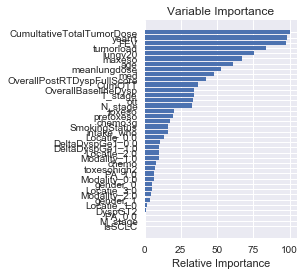

{'Final Score': 0.55303343900699053, 'Training Score': 0.61657963693329454, 'Testing Score': 0.59267906930165515, 'Cross-Val Accuracy': 0.49356499356499361, 'Negative Accuracy': 0.56818181818181823, 'Positive Accuracy': 0.48377581120943952, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['IsSCLC', 'M_stage', 'PA_0.0', 'DyspGT2', 'Locatie_1.0', 'gender_1', 'Modality_2.0', 'Locatie_3.0', 'gender_0', 'Modality_0.0', 'PA_1.0', 'toxesohigh2', 'chemo', 'Modality_1.0', 'Locatie_2.0', 'DeltaDyspGe1_1.0', 'DeltaDyspGe1_0.0', 'Locatie_0.0', 'intake_who', 'SmokingStatus', 'chemo3g', 'pretoxeso', 'toxeso', 'N_stage', 'ott', 'T_stage', 'OverallBaselineDysp', 'CumOTT', 'OverallPostRTDyspFullScore', 'med', 'meanlungdose', 'age', 'maxeso', 'lungv20', 'tumorload', 'FEV', 'yearrt', 'CumultativeTotalTumorDose']}




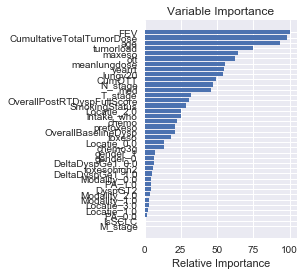

{'Final Score': 0.57900709015837704, 'Training Score': 0.61834006650033024, 'Testing Score': 0.615569517488329, 'Cross-Val Accuracy': 0.52416344916344915, 'Negative Accuracy': 0.36818181818181817, 'Positive Accuracy': 0.63716814159292035, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'PA_0.0', 'Locatie_1.0', 'Locatie_3.0', 'Modality_1.0', 'Modality_2.0', 'DyspGT2', 'PA_1.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'toxesohigh2', 'DeltaDyspGe1_0.0', 'gender_0', 'gender_1', 'chemo3g', 'Locatie_0.0', 'toxeso', 'OverallBaselineDysp', 'pretoxeso', 'chemo', 'intake_who', 'Locatie_2.0', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'T_stage', 'med', 'N_stage', 'CumOTT', 'lungv20', 'yearrt', 'meanlungdose', 'ott', 'maxeso', 'tumorload', 'age', 'CumultativeTotalTumorDose', 'FEV']}




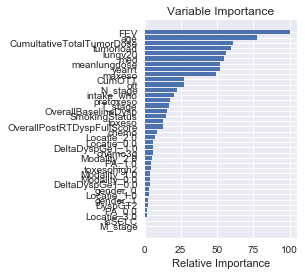

{'Final Score': 0.59618913715338795, 'Training Score': 0.99933667626385547, 'Testing Score': 0.62389309216684341, 'Cross-Val Accuracy': 0.55463320463320465, 'Negative Accuracy': 0.99090909090909096, 'Positive Accuracy': 0.99705014749262533, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'Locatie_3.0', 'PA_0.0', 'DyspGT2', 'gender_1', 'Locatie_1.0', 'gender_0', 'DeltaDyspGe1_0.0', 'Modality_0.0', 'Modality_1.0', 'toxesohigh2', 'PA_1.0', 'Modality_2.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'Locatie_0.0', 'Locatie_2.0', 'chemo', 'OverallPostRTDyspFullScore', 'toxeso', 'SmokingStatus', 'OverallBaselineDysp', 'T_stage', 'pretoxeso', 'intake_who', 'N_stage', 'ott', 'CumOTT', 'maxeso', 'yearrt', 'meanlungdose', 'med', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




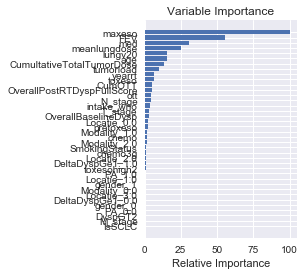

{'Final Score': 0.58061473402116315, 'Training Score': 0.98536548796511081, 'Testing Score': 0.61105244172982354, 'Cross-Val Accuracy': 0.53495817245817245, 'Negative Accuracy': 0.96363636363636362, 'Positive Accuracy': 0.98820058997050142, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['IsSCLC', 'M_stage', 'DyspGT2', 'PA_0.0', 'gender_0', 'DeltaDyspGe1_0.0', 'Locatie_3.0', 'Modality_0.0', 'gender_1', 'Locatie_1.0', 'PA_1.0', 'toxesohigh2', 'DeltaDyspGe1_1.0', 'Locatie_2.0', 'chemo3g', 'SmokingStatus', 'Modality_2.0', 'chemo', 'Modality_1.0', 'pretoxeso', 'Locatie_0.0', 'OverallBaselineDysp', 'T_stage', 'intake_who', 'N_stage', 'ott', 'OverallPostRTDyspFullScore', 'CumOTT', 'toxeso', 'yearrt', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'lungv20', 'meanlungdose', 'med', 'FEV', 'maxeso']}




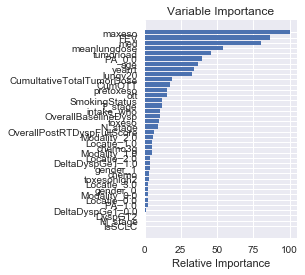

{'Final Score': 0.58097355555736852, 'Training Score': 0.80346297909048658, 'Testing Score': 0.60911937509239666, 'Cross-Val Accuracy': 0.53875482625482618, 'Negative Accuracy': 0.66363636363636369, 'Positive Accuracy': 0.4808259587020649, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['IsSCLC', 'M_stage', 'DyspGT2', 'DeltaDyspGe1_0.0', 'PA_1.0', 'Locatie_0.0', 'Modality_0.0', 'gender_0', 'Locatie_3.0', 'toxesohigh2', 'chemo', 'gender_1', 'DeltaDyspGe1_1.0', 'Locatie_2.0', 'Modality_1.0', 'chemo3g', 'Locatie_1.0', 'Modality_2.0', 'OverallPostRTDyspFullScore', 'N_stage', 'toxeso', 'OverallBaselineDysp', 'intake_who', 'T_stage', 'SmokingStatus', 'ott', 'pretoxeso', 'CumOTT', 'CumultativeTotalTumorDose', 'lungv20', 'yearrt', 'age', 'PA_0.0', 'tumorload', 'meanlungdose', 'med', 'FEV', 'maxeso']}




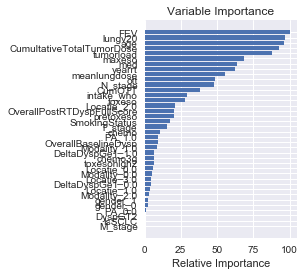

{'Final Score': 0.60549390018757487, 'Training Score': 0.99992728168730527, 'Testing Score': 0.6309711721272967, 'Cross-Val Accuracy': 0.56727799227799225, 'Negative Accuracy': 1.0, 'Positive Accuracy': 0.99705014749262533, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'PA_0.0', 'gender_0', 'gender_1', 'Modality_2.0', 'Locatie_1.0', 'DeltaDyspGe1_0.0', 'Locatie_3.0', 'Modality_0.0', 'Locatie_0.0', 'toxesohigh2', 'chemo3g', 'DeltaDyspGe1_1.0', 'Modality_1.0', 'OverallBaselineDysp', 'PA_1.0', 'chemo', 'T_stage', 'SmokingStatus', 'pretoxeso', 'OverallPostRTDyspFullScore', 'Locatie_2.0', 'toxeso', 'intake_who', 'CumOTT', 'N_stage', 'ott', 'meanlungdose', 'yearrt', 'med', 'maxeso', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'lungv20', 'FEV']}




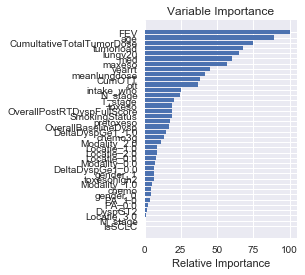

{'Final Score': 0.57777044664961785, 'Training Score': 1.0, 'Testing Score': 0.60622616269144791, 'Cross-Val Accuracy': 0.5350868725868726, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['IsSCLC', 'M_stage', 'Locatie_3.0', 'DyspGT2', 'PA_0.0', 'PA_1.0', 'gender_0', 'chemo', 'Modality_1.0', 'toxesohigh2', 'gender_1', 'DeltaDyspGe1_0.0', 'Modality_0.0', 'Locatie_0.0', 'Locatie_2.0', 'Locatie_1.0', 'Modality_2.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'OverallBaselineDysp', 'pretoxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'toxeso', 'T_stage', 'N_stage', 'intake_who', 'ott', 'CumOTT', 'meanlungdose', 'yearrt', 'maxeso', 'med', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




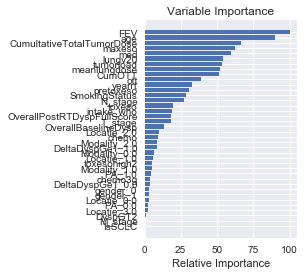

{'Final Score': 0.57458168070684845, 'Training Score': 1.0, 'Testing Score': 0.60452588140116104, 'Cross-Val Accuracy': 0.52966537966537963, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['IsSCLC', 'M_stage', 'DyspGT2', 'Locatie_3.0', 'PA_0.0', 'Locatie_0.0', 'gender_1', 'gender_0', 'DeltaDyspGe1_0.0', 'chemo3g', 'PA_1.0', 'Modality_1.0', 'toxesohigh2', 'Locatie_1.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'Modality_2.0', 'chemo', 'Locatie_2.0', 'OverallBaselineDysp', 'T_stage', 'OverallPostRTDyspFullScore', 'intake_who', 'toxeso', 'N_stage', 'SmokingStatus', 'pretoxeso', 'yearrt', 'ott', 'CumOTT', 'meanlungdose', 'tumorload', 'lungv20', 'med', 'maxeso', 'CumultativeTotalTumorDose', 'age', 'FEV']}




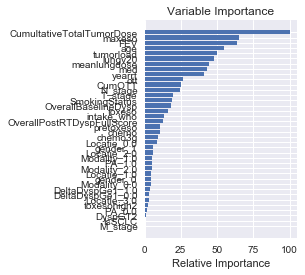

{'Final Score': 0.58378330960611757, 'Training Score': 0.79606553858687412, 'Testing Score': 0.61274052244520227, 'Cross-Val Accuracy': 0.54034749034749041, 'Negative Accuracy': 0.6045454545454545, 'Positive Accuracy': 0.86725663716814161, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'PA_0.0', 'toxesohigh2', 'Locatie_3.0', 'DeltaDyspGe1_0.0', 'DeltaDyspGe1_1.0', 'Modality_0.0', 'gender_0', 'Locatie_1.0', 'Modality_2.0', 'PA_1.0', 'Modality_1.0', 'Locatie_2.0', 'gender_1', 'Locatie_0.0', 'chemo3g', 'chemo', 'pretoxeso', 'OverallPostRTDyspFullScore', 'intake_who', 'toxeso', 'OverallBaselineDysp', 'SmokingStatus', 'T_stage', 'N_stage', 'CumOTT', 'ott', 'yearrt', 'med', 'meanlungdose', 'lungv20', 'tumorload', 'age', 'FEV', 'maxeso', 'CumultativeTotalTumorDose']}




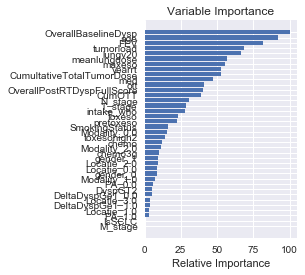

{'Final Score': 0.5901778227796538, 'Training Score': 0.72034738478741811, 'Testing Score': 0.62221829322134492, 'Cross-Val Accuracy': 0.54211711711711708, 'Negative Accuracy': 0.77727272727272723, 'Positive Accuracy': 0.46017699115044247, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'PA_1.0', 'Locatie_1.0', 'DeltaDyspGe1_1.0', 'Locatie_3.0', 'DeltaDyspGe1_0.0', 'DyspGT2', 'PA_0.0', 'Modality_1.0', 'gender_0', 'Locatie_0.0', 'Locatie_2.0', 'gender_1', 'chemo3g', 'Modality_2.0', 'chemo', 'toxesohigh2', 'Modality_0.0', 'SmokingStatus', 'pretoxeso', 'toxeso', 'intake_who', 'T_stage', 'N_stage', 'CumOTT', 'OverallPostRTDyspFullScore', 'ott', 'med', 'CumultativeTotalTumorDose', 'yearrt', 'maxeso', 'meanlungdose', 'lungv20', 'tumorload', 'FEV', 'age', 'OverallBaselineDysp']}




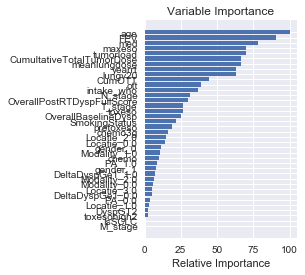

{'Final Score': 0.57152932407511292, 'Training Score': 0.71906956528132526, 'Testing Score': 0.60422197513162323, 'Cross-Val Accuracy': 0.52249034749034751, 'Negative Accuracy': 0.47272727272727272, 'Positive Accuracy': 0.67551622418879054, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'toxesohigh2', 'DyspGT2', 'Locatie_1.0', 'PA_0.0', 'DeltaDyspGe1_0.0', 'Locatie_3.0', 'Modality_0.0', 'Modality_2.0', 'DeltaDyspGe1_1.0', 'gender_1', 'PA_1.0', 'chemo', 'Modality_1.0', 'gender_0', 'Locatie_0.0', 'Locatie_2.0', 'chemo3g', 'pretoxeso', 'SmokingStatus', 'OverallBaselineDysp', 'toxeso', 'T_stage', 'OverallPostRTDyspFullScore', 'N_stage', 'intake_who', 'ott', 'CumOTT', 'lungv20', 'yearrt', 'meanlungdose', 'CumultativeTotalTumorDose', 'tumorload', 'maxeso', 'med', 'FEV', 'age']}




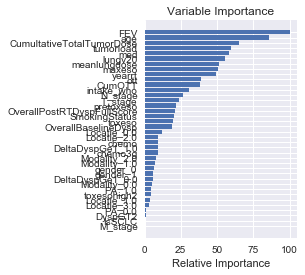

{'Final Score': 0.58364723811830876, 'Training Score': 1.0, 'Testing Score': 0.61132326044171148, 'Cross-Val Accuracy': 0.54213320463320469, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'PA_0.0', 'Locatie_3.0', 'Locatie_1.0', 'toxesohigh2', 'PA_1.0', 'Modality_0.0', 'DeltaDyspGe1_0.0', 'gender_1', 'gender_0', 'Modality_1.0', 'Modality_2.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'chemo', 'Locatie_2.0', 'Locatie_0.0', 'OverallBaselineDysp', 'toxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'pretoxeso', 'T_stage', 'N_stage', 'intake_who', 'CumOTT', 'ott', 'yearrt', 'maxeso', 'meanlungdose', 'lungv20', 'med', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




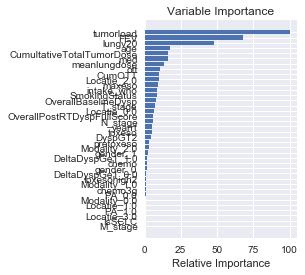

{'Final Score': 0.561554541555359, 'Training Score': 0.99519675914859107, 'Testing Score': 0.59240214240350486, 'Cross-Val Accuracy': 0.51528314028314026, 'Negative Accuracy': 1.0, 'Positive Accuracy': 0.99115044247787609, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'Locatie_3.0', 'PA_1.0', 'Locatie_1.0', 'Modality_0.0', 'PA_0.0', 'chemo3g', 'Modality_1.0', 'toxesohigh2', 'DeltaDyspGe1_0.0', 'gender_0', 'chemo', 'DeltaDyspGe1_1.0', 'gender_1', 'Modality_2.0', 'pretoxeso', 'DyspGT2', 'toxeso', 'yearrt', 'N_stage', 'OverallPostRTDyspFullScore', 'Locatie_0.0', 'T_stage', 'OverallBaselineDysp', 'SmokingStatus', 'intake_who', 'maxeso', 'Locatie_2.0', 'CumOTT', 'ott', 'meanlungdose', 'med', 'CumultativeTotalTumorDose', 'age', 'lungv20', 'FEV', 'tumorload']}




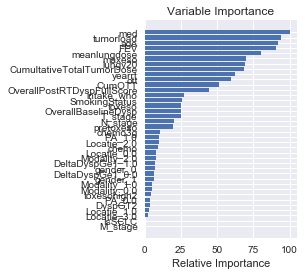

{'Final Score': 0.5566504881389468, 'Training Score': 0.78253739543113832, 'Testing Score': 0.5901918260059239, 'Cross-Val Accuracy': 0.50633848133848125, 'Negative Accuracy': 0.42272727272727273, 'Positive Accuracy': 0.6696165191740413, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'Locatie_3.0', 'Locatie_1.0', 'DyspGT2', 'PA_0.0', 'toxesohigh2', 'Modality_0.0', 'Modality_1.0', 'gender_1', 'DeltaDyspGe1_0.0', 'gender_0', 'DeltaDyspGe1_1.0', 'Modality_2.0', 'Locatie_0.0', 'chemo', 'Locatie_2.0', 'PA_1.0', 'chemo3g', 'pretoxeso', 'N_stage', 'T_stage', 'OverallBaselineDysp', 'toxeso', 'SmokingStatus', 'intake_who', 'OverallPostRTDyspFullScore', 'CumOTT', 'ott', 'yearrt', 'CumultativeTotalTumorDose', 'lungv20', 'maxeso', 'meanlungdose', 'FEV', 'age', 'tumorload', 'med']}




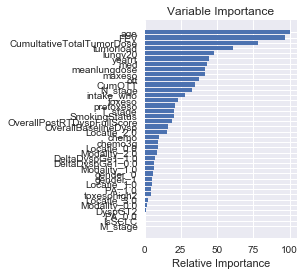

{'Final Score': 0.5723199289782871, 'Training Score': 1.0, 'Testing Score': 0.60073484516544196, 'Cross-Val Accuracy': 0.52969755469755475, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'PA_0.0', 'DyspGT2', 'Modality_0.0', 'Locatie_3.0', 'toxesohigh2', 'PA_1.0', 'Locatie_1.0', 'gender_1', 'gender_0', 'Modality_1.0', 'DeltaDyspGe1_0.0', 'DeltaDyspGe1_1.0', 'Modality_2.0', 'Locatie_0.0', 'chemo3g', 'chemo', 'Locatie_2.0', 'OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'SmokingStatus', 'T_stage', 'pretoxeso', 'toxeso', 'intake_who', 'N_stage', 'CumOTT', 'ott', 'maxeso', 'meanlungdose', 'med', 'yearrt', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'FEV', 'age']}




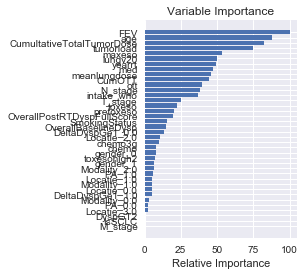

{'Final Score': 0.57364502297088704, 'Training Score': 1.0, 'Testing Score': 0.60297551018528373, 'Cross-Val Accuracy': 0.52964929214929213, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'Locatie_3.0', 'PA_0.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'Locatie_0.0', 'Modality_1.0', 'Locatie_1.0', 'PA_1.0', 'Modality_2.0', 'gender_1', 'toxesohigh2', 'gender_0', 'chemo', 'chemo3g', 'Locatie_2.0', 'DeltaDyspGe1_0.0', 'OverallBaselineDysp', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'pretoxeso', 'toxeso', 'T_stage', 'intake_who', 'N_stage', 'ott', 'CumOTT', 'meanlungdose', 'med', 'yearrt', 'lungv20', 'maxeso', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




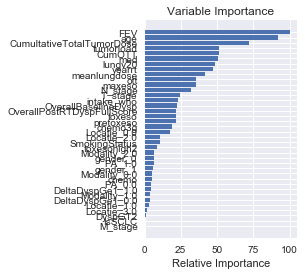

{'Final Score': 0.58321804610298034, 'Training Score': 1.0, 'Testing Score': 0.61057576538398917, 'Cross-Val Accuracy': 0.5421814671814672, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'Locatie_3.0', 'Locatie_1.0', 'DeltaDyspGe1_0.0', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'PA_0.0', 'chemo', 'Modality_0.0', 'gender_1', 'PA_1.0', 'gender_0', 'Modality_2.0', 'toxesohigh2', 'SmokingStatus', 'Locatie_2.0', 'Locatie_0.0', 'chemo3g', 'pretoxeso', 'toxeso', 'OverallPostRTDyspFullScore', 'OverallBaselineDysp', 'intake_who', 'T_stage', 'N_stage', 'maxeso', 'ott', 'meanlungdose', 'yearrt', 'lungv20', 'med', 'CumOTT', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}
Best Run: {'Final Score': 0.61499072682231737, 'Training Score': 0.97531169623063507, 'Testing Score': 0.63972070944002712, 'Cross-Val Accuracy': 0.5778957528957529, 'Negative Accurac

In [17]:
from sklearn import ensemble

def run_boosting(X,Y):
    runs = []
    
    def boosting(depth_max, random, loss, subsample, learn):
        clf = ensemble.GradientBoostingClassifier(max_depth=depth_max, random_state=random, loss=loss,
                subsample=ss, learning_rate = learn)
        clf.fit(X, Y)

        results = recall_score(clf, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        results['Loss'] = loss
        results['Subsample'] = ss
        results['Learning Rate'] = learn

        print("\n")

        feature_importance = clf.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.subplot(1, 2, 2)
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Variable Importance')
        plt.show()

        sorted_col = X.columns[sorted_idx].tolist()
        
        results['feature list'] = sorted_col
        runs.append(results)
        print(results)
    
    depth_maxs = [3,5,10]
    randoms = [1]
    losses = ['deviance']
    subsamples = [0.1, 0.5, 1]
    learning_rates = [0.1, 0.5, 1]

    for depth_max in depth_maxs:
        for random in randoms:
            for loss in losses:
                for ss in subsamples:
                    for learn in learning_rates:
                        boosting (depth_max, random, loss, ss, learn)
                        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    features = runs[-1]['feature list']
    print(type(features))
    return features

best_features = run_boosting(X,Y)

In [18]:
reduced_features = best_features[19:]
print(reduced_features)

['SmokingStatus', 'T_stage', 'OverallPostRTDyspFullScore', 'toxeso', 'pretoxeso', 'OverallBaselineDysp', 'N_stage', 'intake_who', 'CumOTT', 'ott', 'yearrt', 'med', 'maxeso', 'CumultativeTotalTumorDose', 'lungv20', 'meanlungdose', 'tumorload', 'FEV', 'age']


In [19]:
X2 = X[reduced_features]
print(X2.head())

   SmokingStatus  T_stage  OverallPostRTDyspFullScore  toxeso  pretoxeso  \
0       1.252155      0.0                           0     2.0        2.0   
1       1.000000      3.0                           1     2.0        2.0   
2       1.000000      1.0                           1     1.0        0.0   
3       1.000000      1.0                           1     1.0        1.0   
4       1.000000      1.0                           2     0.0        0.0   

   OverallBaselineDysp  N_stage  intake_who  CumOTT  ott  yearrt        med  \
0                  0.0      2.0         2.0      21   21  2010.0  17.034600   
1                  1.0      2.0         1.0      36   36  2014.0  20.334135   
2                  0.0      3.0         1.0      24   24  2010.0  20.334135   
3                  1.0      3.0         1.0      36   36  2013.0  17.229800   
4                  2.0      2.0         2.0      28   28  2013.0  20.334135   

      maxeso  CumultativeTotalTumorDose    lungv20  meanlungdose   t

In [20]:
run_logistic(X2, Y, 'l1')

C = 0.0001

    coefficients                     columns  abs
0            0.0               SmokingStatus  0.0
10           0.0                      yearrt  0.0
17           0.0                         FEV  0.0
16           0.0                   tumorload  0.0
15           0.0                meanlungdose  0.0
14           0.0                     lungv20  0.0
13           0.0   CumultativeTotalTumorDose  0.0
12           0.0                      maxeso  0.0
11           0.0                         med  0.0
9            0.0                         ott  0.0
1            0.0                     T_stage  0.0
8            0.0                      CumOTT  0.0
7            0.0                  intake_who  0.0
6            0.0                     N_stage  0.0
5            0.0         OverallBaselineDysp  0.0
4            0.0                   pretoxeso  0.0
3            0.0                      toxeso  0.0
2            0.0  OverallPostRTDyspFullScore  0.0
18           0.0                      

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pred


    coefficients                     columns       abs
10      0.312017                      yearrt  0.312017
9      -0.201284                         ott  0.201284
14      0.175535                     lungv20  0.175535
6       0.168416                     N_stage  0.168416
16      0.161192                   tumorload  0.161192
2       0.120833  OverallPostRTDyspFullScore  0.120833
17     -0.105428                         FEV  0.105428
3       0.085008                      toxeso  0.085008
13     -0.054251   CumultativeTotalTumorDose  0.054251
7       0.046960                  intake_who  0.046960
18      0.022055                         age  0.022055
11      0.000000                         med  0.000000
12      0.000000                      maxeso  0.000000
1       0.000000                     T_stage  0.000000
8       0.000000                      CumOTT  0.000000
15      0.000000                meanlungdose  0.000000
5       0.000000         OverallBaselineDysp  0.000000
4       0

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.64880323315402588, 'Training Score': 0.70057936953223821, 'Testing Score': 0.67466776525241989, 'Cross-Val Accuracy': 0.61000643500643492, 'Negative Accuracy': 0.40000000000000002, 'Positive Accuracy': 0.82005899705014751, 'alpha': 0.3}
C = 0.5

    coefficients                     columns       abs
10      0.371695                      yearrt  0.371695
16      0.319081                   tumorload  0.319081
14      0.308344                     lungv20  0.308344
9      -0.288318                         ott  0.288318
6       0.283614                     N_stage  0.283614
3       0.269896                      toxeso  0.269896
11     -0.251397                         med  0.251397
17     -0.216704                         FEV  0.216704
2       0.213714  OverallPostRTDyspFullScore  0.213714
5      -0.161630         OverallBaselineDysp  0.161630
4      -0.156195                   pretoxeso  0.156195
7       0.148155                  intake_who  0.148155
13     -0.090763   Cu

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.65850663125609532, 'Training Score': 0.70766156206670516, 'Testing Score': 0.68487698945942965, 'Cross-Val Accuracy': 0.61895109395109382, 'Negative Accuracy': 0.43636363636363634, 'Positive Accuracy': 0.82595870206489674, 'alpha': 1}
C = 100

    coefficients                     columns       abs
9      -0.765831                         ott  0.765831
8       0.449743                      CumOTT  0.449743
11     -0.391490                         med  0.391490
10      0.383129                      yearrt  0.383129
16      0.382272                   tumorload  0.382272
3       0.330014                      toxeso  0.330014
14      0.324182                     lungv20  0.324182
6       0.321487                     N_stage  0.321487
17     -0.249128                         FEV  0.249128
2       0.248372  OverallPostRTDyspFullScore  0.248372
5      -0.220416         OverallBaselineDysp  0.220416
4      -0.198694                   pretoxeso  0.198694
7       0.179121       

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66373902313223621, 'Training Score': 0.7100142676209622, 'Testing Score': 0.69002621401490249, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.45000000000000001, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100}
C = 1000

    coefficients                     columns       abs
9      -7.298609                         ott  7.298609
8       6.982001                      CumOTT  6.982001
11     -0.392486                         med  0.392486
16      0.381969                   tumorload  0.381969
10      0.380296                      yearrt  0.380296
3       0.331191                      toxeso  0.331191
14      0.324672                     lungv20  0.324672
6       0.320188                     N_stage  0.320188
17     -0.249480                         FEV  0.249480
2       0.245773  OverallPostRTDyspFullScore  0.245773
5      -0.220293         OverallBaselineDysp  0.220293
4      -0.198767                   pretoxeso  0.198767
7       0.181372     

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66261237173530574, 'Training Score': 0.7099138180311545, 'Testing Score': 0.68814846168668498, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.44545454545454544, 'Positive Accuracy': 0.81710914454277284, 'alpha': 1000}
C = 100000.0

    coefficients                     columns       abs
9      -9.384842                         ott  9.384842
8       9.067817                      CumOTT  9.067817
11     -0.392664                         med  0.392664
16      0.381850                   tumorload  0.381850
10      0.379633                      yearrt  0.379633
3       0.331481                      toxeso  0.331481
14      0.324716                     lungv20  0.324716
6       0.319872                     N_stage  0.319872
17     -0.249526                         FEV  0.249526
2       0.245149  OverallPostRTDyspFullScore  0.245149
5      -0.220225         OverallBaselineDysp  0.220225
4      -0.198760                   pretoxeso  0.198760
7       0.181869

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66261237173530574, 'Training Score': 0.71061634004607943, 'Testing Score': 0.68814846168668498, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.44545454545454544, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100000.0}
C = 10000000.0

    coefficients                     columns       abs
9      -9.387081                         ott  9.387081
8       9.070028                      CumOTT  9.070028
11     -0.392651                         med  0.392651
16      0.381858                   tumorload  0.381858
10      0.379633                      yearrt  0.379633
3       0.331465                      toxeso  0.331465
14      0.324742                     lungv20  0.324742
6       0.319875                     N_stage  0.319875
17     -0.249528                         FEV  0.249528
2       0.245161  OverallPostRTDyspFullScore  0.245161
5      -0.220230         OverallBaselineDysp  0.220230
4      -0.198777                   pretoxeso  0.198777
7       0

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66261237173530574, 'Training Score': 0.7103788775086437, 'Testing Score': 0.68814846168668498, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.44545454545454544, 'Positive Accuracy': 0.81710914454277284, 'alpha': 10000000.0}
C = 1000000000.0

    coefficients                     columns       abs
9      -6.598403                         ott  6.598403
8       6.281598                      CumOTT  6.281598
11     -0.392540                         med  0.392540
16      0.382040                   tumorload  0.382040
10      0.380548                      yearrt  0.380548
3       0.331196                      toxeso  0.331196
14      0.324603                     lungv20  0.324603
6       0.320346                     N_stage  0.320346
17     -0.249465                         FEV  0.249465
2       0.246021  OverallPostRTDyspFullScore  0.246021
5      -0.220345         OverallBaselineDysp  0.220345
4      -0.198801                   pretoxeso  0.198801
7     

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66261237173530574, 'Training Score': 0.71061634004607943, 'Testing Score': 0.68814846168668498, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.44545454545454544, 'Positive Accuracy': 0.81710914454277284, 'alpha': 1000000000.0}
Best Run: {'Final Score': 0.66373902313223621, 'Training Score': 0.7100142676209622, 'Testing Score': 0.69002621401490249, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.45000000000000001, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100}


Score is 66.19, alpha = 1e9.

In [21]:
run_logistic(X2, Y, 'l2')

C = 0.0001

    coefficients                     columns       abs
10      0.005311                      yearrt  0.005311
9      -0.004703                         ott  0.004703
8      -0.004696                      CumOTT  0.004696
14      0.004166                     lungv20  0.004166
13     -0.003842   CumultativeTotalTumorDose  0.003842
16      0.003653                   tumorload  0.003653
6       0.003574                     N_stage  0.003574
2       0.003386  OverallPostRTDyspFullScore  0.003386
7       0.002655                  intake_who  0.002655
11      0.002538                         med  0.002538
17     -0.002510                         FEV  0.002510
3       0.002502                      toxeso  0.002502
12      0.002149                      maxeso  0.002149
15      0.002002                meanlungdose  0.002002
18      0.001773                         age  0.001773
0      -0.000879               SmokingStatus  0.000879
4      -0.000841                   pretoxeso  0.00084

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.65751485775728247, 'Training Score': 0.70991046362988097, 'Testing Score': 0.68441450981855101, 'Cross-Val Accuracy': 0.61716537966537965, 'Negative Accuracy': 0.42727272727272725, 'Positive Accuracy': 0.80530973451327437, 'alpha': 0.1}
C = 0.3

    coefficients                     columns       abs
10      0.372479                      yearrt  0.372479
16      0.350235                   tumorload  0.350235
11     -0.336496                         med  0.336496
3       0.303888                      toxeso  0.303888
6       0.303522                     N_stage  0.303522
14      0.302741                     lungv20  0.302741
17     -0.235852                         FEV  0.235852
2       0.234293  OverallPostRTDyspFullScore  0.234293
5      -0.200217         OverallBaselineDysp  0.200217
4      -0.181426                   pretoxeso  0.181426
7       0.168152                  intake_who  0.168152
9      -0.157909                         ott  0.157909
8      -0.146400     

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66373902313223621, 'Training Score': 0.71047796830964116, 'Testing Score': 0.69002621401490249, 'Cross-Val Accuracy': 0.62430823680823688, 'Negative Accuracy': 0.45000000000000001, 'Positive Accuracy': 0.81710914454277284, 'alpha': 100}
C = 1000

    coefficients                     columns       abs
9      -8.550509                         ott  8.550509
8       8.233678                      CumOTT  8.233678
11     -0.392591                         med  0.392591
16      0.381903                   tumorload  0.381903
10      0.379880                      yearrt  0.379880
3       0.331381                      toxeso  0.331381
14      0.324704                     lungv20  0.324704
6       0.319988                     N_stage  0.319988
17     -0.249512                         FEV  0.249512
2       0.245387  OverallPostRTDyspFullScore  0.245387
5      -0.220256         OverallBaselineDysp  0.220256
4      -0.198777                   pretoxeso  0.198777
7       0.181682    

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.66189808602101996, 'Training Score': 0.71038405612519873, 'Testing Score': 0.68814846168668498, 'Cross-Val Accuracy': 0.62252252252252249, 'Negative Accuracy': 0.44545454545454544, 'Positive Accuracy': 0.81710914454277284, 'alpha': 10000000.0}
C = 1000000000.0

    coefficients                     columns        abs
9     -28.382866                         ott  28.382866
8      28.064364                      CumOTT  28.064364
11     -0.392985                         med   0.392985
16      0.381359                   tumorload   0.381359
10      0.377224                      yearrt   0.377224
3       0.332298                      toxeso   0.332298
14      0.325045                     lungv20   0.325045
6       0.318680                     N_stage   0.318680
17     -0.249690                         FEV   0.249690
2       0.242853  OverallPostRTDyspFullScore   0.242853
5      -0.219888         OverallBaselineDysp   0.219888
4      -0.198661                   pretoxeso   0

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Score is 66.37, alpha = 1000.

Largest feature coefficients are: OTT, med, FEV, OverallBaselineDysp, pretoxeso, CumulativeTutalTumorDose, T_stage, SmokingSTatus.

In [22]:
run_tree(X2, Y)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
{'Final Score': 0.59647378007901497, 'Training Score': 0.68342748318446822, 'Testing Score': 0.62078534346073488, 'Cross-Val Accuracy': 0.5600064350064351, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 4}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
{'Final Score': 0.59647378007901497, 'Training Score': 0.68342748318446822, 'Testing Score': 0.62078534346073488, 'Cross-Val Accuracy': 0.5600064350064351, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 5}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
{'Final Score': 0.59647378007901497, 'Training Score': 0.68342748318446822, 'Testing Score': 0.62078534346073488, 'Cross-Val Accuracy': 0.5600064350064351, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'Max Depth': 3, '

In [23]:
run_forest(X2, Y)

Max Depth: 3, Max Feature = 4, Number of Trees = 10, Random State = 1, Min Samples Split: 4
{'Final Score': 0.60909055300823212, 'Training Score': 0.71082174575134649, 'Testing Score': 0.62750613403559918, 'Cross-Val Accuracy': 0.58146718146718146, 'Negative Accuracy': 0.33636363636363636, 'Positive Accuracy': 0.89085545722713866, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 10, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 50, Random State = 1, Min Samples Split: 4
{'Final Score': 0.61073406771231231, 'Training Score': 0.70843917682956092, 'Testing Score': 0.6278643728281138, 'Cross-Val Accuracy': 0.58503861003861002, 'Negative Accuracy': 0.29545454545454547, 'Positive Accuracy': 0.92035398230088494, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 50, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 100, Random State = 1, Min Samples Split: 4
{'Final Score': 0.61182095959601779, '

In [24]:
run_svc(X2, Y)

Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.3
Gamma = 0.02857142857142857
Kernel:

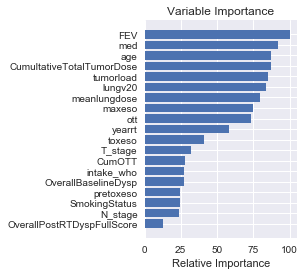

{'Final Score': 0.61451128751476392, 'Training Score': 0.80687963143928965, 'Testing Score': 0.64005849506428913, 'Cross-Val Accuracy': 0.57619047619047614, 'Negative Accuracy': 0.65454545454545454, 'Positive Accuracy': 0.86135693215339237, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['OverallPostRTDyspFullScore', 'N_stage', 'SmokingStatus', 'pretoxeso', 'OverallBaselineDysp', 'intake_who', 'CumOTT', 'T_stage', 'toxeso', 'yearrt', 'ott', 'maxeso', 'meanlungdose', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'med', 'FEV']}




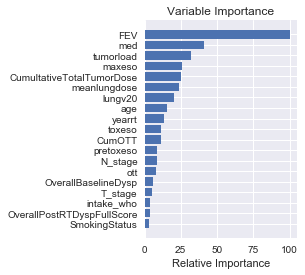

{'Final Score': 0.56877204972353768, 'Training Score': 0.60030076308078251, 'Testing Score': 0.59032793358041347, 'Cross-Val Accuracy': 0.53643822393822393, 'Negative Accuracy': 0.70454545454545459, 'Positive Accuracy': 0.46017699115044247, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['SmokingStatus', 'OverallPostRTDyspFullScore', 'intake_who', 'T_stage', 'OverallBaselineDysp', 'ott', 'N_stage', 'pretoxeso', 'CumOTT', 'toxeso', 'yearrt', 'age', 'lungv20', 'meanlungdose', 'CumultativeTotalTumorDose', 'maxeso', 'tumorload', 'med', 'FEV']}




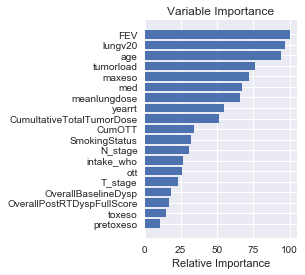

{'Final Score': 0.48503112750246963, 'Training Score': 0.58103574756311616, 'Testing Score': 0.51615012026902374, 'Cross-Val Accuracy': 0.43835263835263838, 'Negative Accuracy': 0.18636363636363637, 'Positive Accuracy': 0.93805309734513276, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['pretoxeso', 'toxeso', 'OverallPostRTDyspFullScore', 'OverallBaselineDysp', 'T_stage', 'ott', 'intake_who', 'N_stage', 'SmokingStatus', 'CumOTT', 'CumultativeTotalTumorDose', 'yearrt', 'meanlungdose', 'med', 'maxeso', 'tumorload', 'age', 'lungv20', 'FEV']}




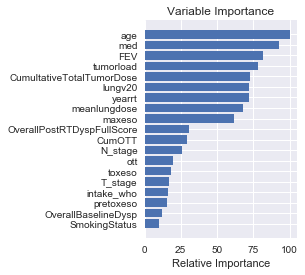

{'Final Score': 0.59512955626879749, 'Training Score': 0.93751185131861536, 'Testing Score': 0.62087229777103303, 'Cross-Val Accuracy': 0.55651544401544406, 'Negative Accuracy': 0.84999999999999998, 'Positive Accuracy': 0.95870206489675514, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['SmokingStatus', 'OverallBaselineDysp', 'pretoxeso', 'intake_who', 'T_stage', 'toxeso', 'ott', 'N_stage', 'CumOTT', 'OverallPostRTDyspFullScore', 'maxeso', 'meanlungdose', 'yearrt', 'lungv20', 'CumultativeTotalTumorDose', 'tumorload', 'FEV', 'med', 'age']}




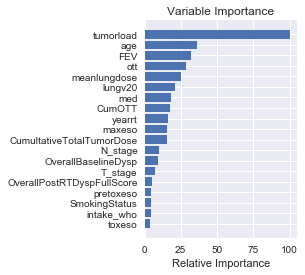

{'Final Score': 0.60680105159791531, 'Training Score': 0.97848552195312455, 'Testing Score': 0.63198073164217117, 'Cross-Val Accuracy': 0.56903153153153152, 'Negative Accuracy': 0.8545454545454545, 'Positive Accuracy': 0.92920353982300885, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['toxeso', 'intake_who', 'SmokingStatus', 'pretoxeso', 'OverallPostRTDyspFullScore', 'T_stage', 'OverallBaselineDysp', 'N_stage', 'CumultativeTotalTumorDose', 'maxeso', 'yearrt', 'CumOTT', 'med', 'lungv20', 'meanlungdose', 'ott', 'FEV', 'age', 'tumorload']}




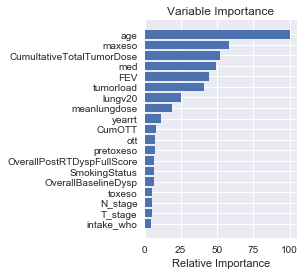

{'Final Score': 0.52735008887874901, 'Training Score': 0.76661181936994494, 'Testing Score': 0.55929004517114556, 'Cross-Val Accuracy': 0.47944015444015442, 'Negative Accuracy': 0.71363636363636362, 'Positive Accuracy': 0.75221238938053092, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['intake_who', 'T_stage', 'N_stage', 'toxeso', 'OverallBaselineDysp', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'pretoxeso', 'ott', 'CumOTT', 'yearrt', 'meanlungdose', 'lungv20', 'tumorload', 'FEV', 'med', 'CumultativeTotalTumorDose', 'maxeso', 'age']}




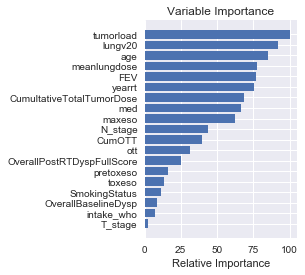

{'Final Score': 0.59364250096818028, 'Training Score': 0.94100474630333208, 'Testing Score': 0.62076409964023183, 'Cross-Val Accuracy': 0.55296010296010301, 'Negative Accuracy': 0.84090909090909094, 'Positive Accuracy': 0.97935103244837762, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['T_stage', 'intake_who', 'OverallBaselineDysp', 'SmokingStatus', 'toxeso', 'pretoxeso', 'OverallPostRTDyspFullScore', 'ott', 'CumOTT', 'N_stage', 'maxeso', 'med', 'CumultativeTotalTumorDose', 'yearrt', 'FEV', 'meanlungdose', 'age', 'lungv20', 'tumorload']}




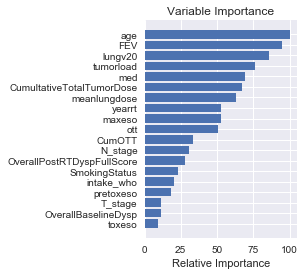

{'Final Score': 0.55222419445119997, 'Training Score': 1.0, 'Testing Score': 0.58394079598580517, 'Cross-Val Accuracy': 0.50464929214929222, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['toxeso', 'OverallBaselineDysp', 'T_stage', 'pretoxeso', 'intake_who', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'N_stage', 'CumOTT', 'ott', 'maxeso', 'yearrt', 'meanlungdose', 'CumultativeTotalTumorDose', 'med', 'tumorload', 'lungv20', 'FEV', 'age']}




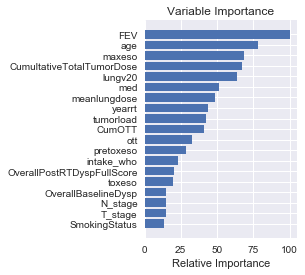

{'Final Score': 0.59139983866125467, 'Training Score': 1.0, 'Testing Score': 0.61821680531916545, 'Cross-Val Accuracy': 0.55117438867438862, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['SmokingStatus', 'T_stage', 'N_stage', 'OverallBaselineDysp', 'toxeso', 'OverallPostRTDyspFullScore', 'intake_who', 'pretoxeso', 'ott', 'CumOTT', 'tumorload', 'yearrt', 'meanlungdose', 'med', 'lungv20', 'CumultativeTotalTumorDose', 'maxeso', 'age', 'FEV']}




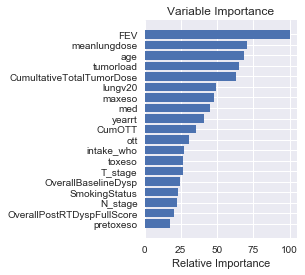

{'Final Score': 0.57928275750088931, 'Training Score': 0.82866284239506116, 'Testing Score': 0.60874668077690042, 'Cross-Val Accuracy': 0.5350868725868726, 'Negative Accuracy': 0.80000000000000004, 'Positive Accuracy': 0.9056047197640118, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['pretoxeso', 'OverallPostRTDyspFullScore', 'N_stage', 'SmokingStatus', 'OverallBaselineDysp', 'T_stage', 'toxeso', 'intake_who', 'ott', 'CumOTT', 'yearrt', 'med', 'maxeso', 'lungv20', 'CumultativeTotalTumorDose', 'tumorload', 'age', 'meanlungdose', 'FEV']}




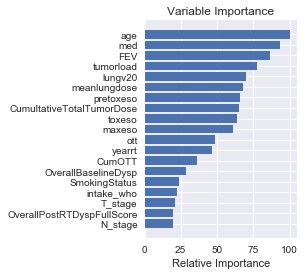

{'Final Score': 0.54773233883094086, 'Training Score': 0.55554062762236289, 'Testing Score': 0.58607470457237465, 'Cross-Val Accuracy': 0.49021879021879017, 'Negative Accuracy': 0.49090909090909091, 'Positive Accuracy': 0.56342182890855452, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['N_stage', 'OverallPostRTDyspFullScore', 'T_stage', 'intake_who', 'SmokingStatus', 'OverallBaselineDysp', 'CumOTT', 'yearrt', 'ott', 'maxeso', 'toxeso', 'CumultativeTotalTumorDose', 'pretoxeso', 'meanlungdose', 'lungv20', 'tumorload', 'FEV', 'med', 'age']}




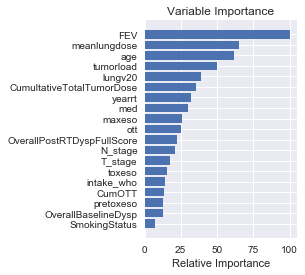

{'Final Score': 0.48628199868893995, 'Training Score': 0.57558917558089728, 'Testing Score': 0.50518256752746971, 'Cross-Val Accuracy': 0.45793114543114538, 'Negative Accuracy': 0.80454545454545456, 'Positive Accuracy': 0.25073746312684364, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['SmokingStatus', 'OverallBaselineDysp', 'pretoxeso', 'CumOTT', 'intake_who', 'toxeso', 'T_stage', 'N_stage', 'OverallPostRTDyspFullScore', 'ott', 'maxeso', 'med', 'yearrt', 'CumultativeTotalTumorDose', 'lungv20', 'tumorload', 'age', 'meanlungdose', 'FEV']}




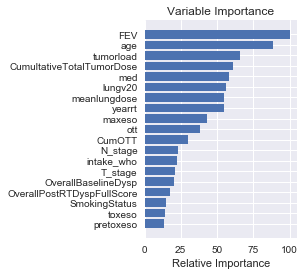

{'Final Score': 0.59749890797397009, 'Training Score': 0.99860063421501644, 'Testing Score': 0.62250461496305176, 'Cross-Val Accuracy': 0.5599903474903476, 'Negative Accuracy': 0.99545454545454548, 'Positive Accuracy': 0.99705014749262533, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['pretoxeso', 'toxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'OverallBaselineDysp', 'T_stage', 'intake_who', 'N_stage', 'CumOTT', 'ott', 'maxeso', 'yearrt', 'meanlungdose', 'lungv20', 'med', 'CumultativeTotalTumorDose', 'tumorload', 'age', 'FEV']}




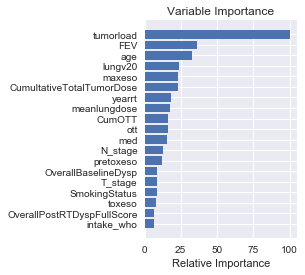

{'Final Score': 0.57744178077836095, 'Training Score': 0.99756707239664755, 'Testing Score': 0.60813441369538068, 'Cross-Val Accuracy': 0.53140283140283129, 'Negative Accuracy': 0.99545454545454548, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['intake_who', 'OverallPostRTDyspFullScore', 'toxeso', 'SmokingStatus', 'T_stage', 'OverallBaselineDysp', 'pretoxeso', 'N_stage', 'med', 'ott', 'CumOTT', 'meanlungdose', 'yearrt', 'CumultativeTotalTumorDose', 'maxeso', 'lungv20', 'age', 'FEV', 'tumorload']}




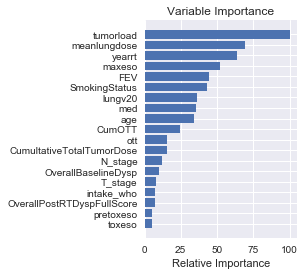

{'Final Score': 0.57365636406408271, 'Training Score': 0.77603618198335911, 'Testing Score': 0.60660874062160508, 'Cross-Val Accuracy': 0.52422779922779916, 'Negative Accuracy': 0.80000000000000004, 'Positive Accuracy': 0.19764011799410031, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['toxeso', 'pretoxeso', 'OverallPostRTDyspFullScore', 'intake_who', 'T_stage', 'OverallBaselineDysp', 'N_stage', 'CumultativeTotalTumorDose', 'ott', 'CumOTT', 'age', 'med', 'lungv20', 'SmokingStatus', 'FEV', 'maxeso', 'yearrt', 'meanlungdose', 'tumorload']}




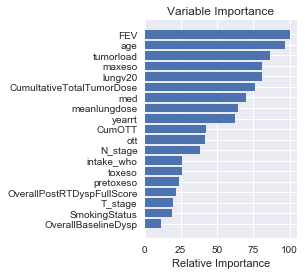

{'Final Score': 0.58314095663443366, 'Training Score': 0.99933667626385547, 'Testing Score': 0.61040438289351129, 'Cross-Val Accuracy': 0.54224581724581722, 'Negative Accuracy': 0.99090909090909096, 'Positive Accuracy': 0.99705014749262533, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['OverallBaselineDysp', 'SmokingStatus', 'T_stage', 'OverallPostRTDyspFullScore', 'pretoxeso', 'toxeso', 'intake_who', 'N_stage', 'ott', 'CumOTT', 'yearrt', 'meanlungdose', 'med', 'CumultativeTotalTumorDose', 'lungv20', 'maxeso', 'tumorload', 'age', 'FEV']}




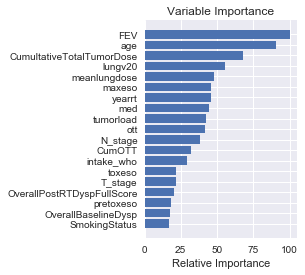

{'Final Score': 0.59013640664046552, 'Training Score': 1.0, 'Testing Score': 0.61730156147499282, 'Cross-Val Accuracy': 0.54938867438867445, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['SmokingStatus', 'OverallBaselineDysp', 'pretoxeso', 'OverallPostRTDyspFullScore', 'T_stage', 'toxeso', 'intake_who', 'CumOTT', 'N_stage', 'ott', 'tumorload', 'med', 'yearrt', 'maxeso', 'meanlungdose', 'lungv20', 'CumultativeTotalTumorDose', 'age', 'FEV']}




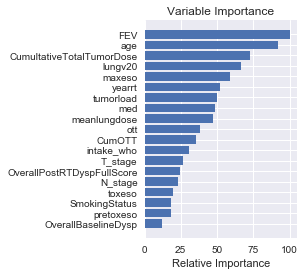

{'Final Score': 0.59366430073463106, 'Training Score': 1.0, 'Testing Score': 0.61965285643674028, 'Cross-Val Accuracy': 0.55468146718146716, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['OverallBaselineDysp', 'pretoxeso', 'SmokingStatus', 'toxeso', 'N_stage', 'OverallPostRTDyspFullScore', 'T_stage', 'intake_who', 'CumOTT', 'ott', 'meanlungdose', 'med', 'tumorload', 'yearrt', 'maxeso', 'lungv20', 'CumultativeTotalTumorDose', 'age', 'FEV']}




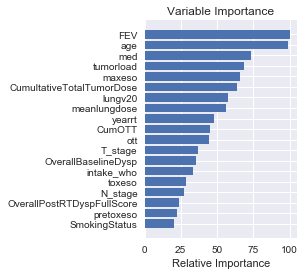

{'Final Score': 0.6074431899963888, 'Training Score': 0.85104126779105527, 'Testing Score': 0.6378450421003734, 'Cross-Val Accuracy': 0.56184041184041189, 'Negative Accuracy': 0.73636363636363633, 'Positive Accuracy': 0.88495575221238942, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['SmokingStatus', 'pretoxeso', 'OverallPostRTDyspFullScore', 'N_stage', 'toxeso', 'intake_who', 'OverallBaselineDysp', 'T_stage', 'ott', 'CumOTT', 'yearrt', 'meanlungdose', 'lungv20', 'CumultativeTotalTumorDose', 'maxeso', 'tumorload', 'med', 'age', 'FEV']}




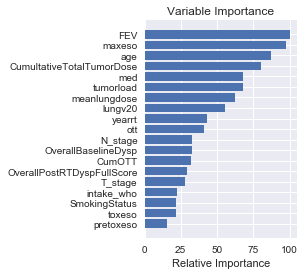

{'Final Score': 0.59485495162046453, 'Training Score': 0.71584754356417413, 'Testing Score': 0.62406112700364857, 'Cross-Val Accuracy': 0.55104568854568858, 'Negative Accuracy': 0.49545454545454548, 'Positive Accuracy': 0.72861356932153387, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['pretoxeso', 'toxeso', 'SmokingStatus', 'intake_who', 'T_stage', 'OverallPostRTDyspFullScore', 'CumOTT', 'OverallBaselineDysp', 'N_stage', 'ott', 'yearrt', 'lungv20', 'meanlungdose', 'tumorload', 'med', 'CumultativeTotalTumorDose', 'age', 'maxeso', 'FEV']}




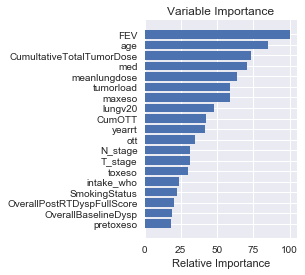

{'Final Score': 0.6266678627682345, 'Training Score': 0.71744299518674515, 'Testing Score': 0.65911825261887214, 'Cross-Val Accuracy': 0.57799227799227793, 'Negative Accuracy': 0.78181818181818186, 'Positive Accuracy': 0.41002949852507375, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['pretoxeso', 'OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'SmokingStatus', 'intake_who', 'toxeso', 'T_stage', 'N_stage', 'ott', 'yearrt', 'CumOTT', 'lungv20', 'maxeso', 'tumorload', 'meanlungdose', 'med', 'CumultativeTotalTumorDose', 'age', 'FEV']}




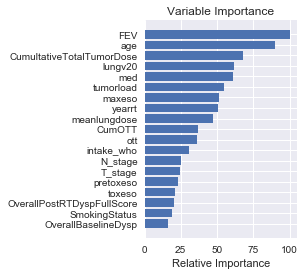

{'Final Score': 0.60843822816062942, 'Training Score': 1.0, 'Testing Score': 0.63478443432176967, 'Cross-Val Accuracy': 0.56891891891891899, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['OverallBaselineDysp', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'toxeso', 'pretoxeso', 'T_stage', 'N_stage', 'intake_who', 'ott', 'CumOTT', 'meanlungdose', 'yearrt', 'maxeso', 'tumorload', 'med', 'lungv20', 'CumultativeTotalTumorDose', 'age', 'FEV']}




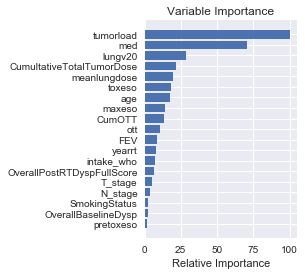

{'Final Score': 0.60884759578990844, 'Training Score': 0.99301534190060947, 'Testing Score': 0.63543453867172639, 'Cross-Val Accuracy': 0.56896718146718139, 'Negative Accuracy': 0.98636363636363633, 'Positive Accuracy': 0.99115044247787609, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['pretoxeso', 'OverallBaselineDysp', 'SmokingStatus', 'N_stage', 'T_stage', 'OverallPostRTDyspFullScore', 'intake_who', 'yearrt', 'FEV', 'ott', 'CumOTT', 'maxeso', 'age', 'toxeso', 'meanlungdose', 'CumultativeTotalTumorDose', 'lungv20', 'med', 'tumorload']}




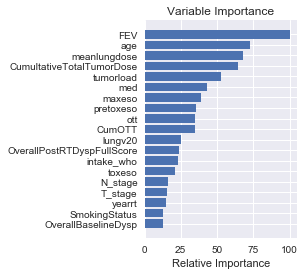

{'Final Score': 0.5920187931693216, 'Training Score': 0.76191765534749245, 'Testing Score': 0.62289489981244728, 'Cross-Val Accuracy': 0.54570463320463314, 'Negative Accuracy': 0.52272727272727271, 'Positive Accuracy': 0.69911504424778759, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['OverallBaselineDysp', 'SmokingStatus', 'yearrt', 'T_stage', 'N_stage', 'toxeso', 'intake_who', 'OverallPostRTDyspFullScore', 'lungv20', 'CumOTT', 'ott', 'pretoxeso', 'maxeso', 'med', 'tumorload', 'CumultativeTotalTumorDose', 'meanlungdose', 'age', 'FEV']}




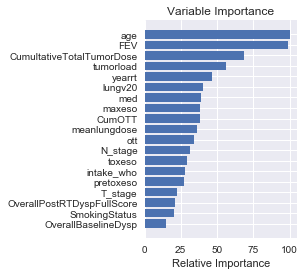

{'Final Score': 0.56662120465785115, 'Training Score': 1.0, 'Testing Score': 0.59479767485875246, 'Cross-Val Accuracy': 0.52435649935649931, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['OverallBaselineDysp', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'T_stage', 'pretoxeso', 'intake_who', 'toxeso', 'N_stage', 'ott', 'meanlungdose', 'CumOTT', 'maxeso', 'med', 'lungv20', 'yearrt', 'tumorload', 'CumultativeTotalTumorDose', 'FEV', 'age']}




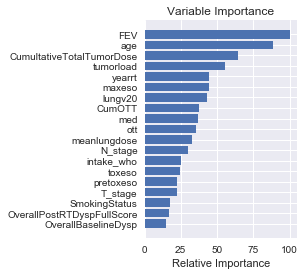

{'Final Score': 0.57408413828023463, 'Training Score': 1.0, 'Testing Score': 0.60250616783299504, 'Cross-Val Accuracy': 0.53145109395109391, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'SmokingStatus', 'T_stage', 'pretoxeso', 'toxeso', 'intake_who', 'N_stage', 'meanlungdose', 'ott', 'med', 'CumOTT', 'lungv20', 'maxeso', 'yearrt', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




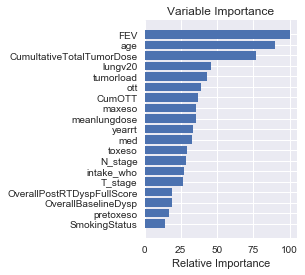

{'Final Score': 0.6070333871493846, 'Training Score': 1.0, 'Testing Score': 0.63240013259346162, 'Cross-Val Accuracy': 0.56898326898326901, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['SmokingStatus', 'pretoxeso', 'OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'T_stage', 'intake_who', 'N_stage', 'toxeso', 'med', 'yearrt', 'meanlungdose', 'maxeso', 'CumOTT', 'ott', 'tumorload', 'lungv20', 'CumultativeTotalTumorDose', 'age', 'FEV']}
Best Run: {'Final Score': 0.6266678627682345, 'Training Score': 0.71744299518674515, 'Testing Score': 0.65911825261887214, 'Cross-Val Accuracy': 0.57799227799227793, 'Negative Accuracy': 0.78181818181818186, 'Positive Accuracy': 0.41002949852507375, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['pretoxeso', 'OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'SmokingStatus'

['pretoxeso',
 'OverallBaselineDysp',
 'OverallPostRTDyspFullScore',
 'SmokingStatus',
 'intake_who',
 'toxeso',
 'T_stage',
 'N_stage',
 'ott',
 'yearrt',
 'CumOTT',
 'lungv20',
 'maxeso',
 'tumorload',
 'meanlungdose',
 'med',
 'CumultativeTotalTumorDose',
 'age',
 'FEV']

In [25]:
run_boosting(X2, Y)

Now that we have tried one method of feature reduction, let's try another: PCA. First we will standardize the dataset, then identify its eigenvector components. Then we will use those components to transform the original dataset into a new dataset where the features explain more variance.

Percentage of total variance in dataset explained by each component:
 [  1.15504904e-01   9.01267318e-02   7.32350456e-02   6.66738740e-02
   6.02442620e-02   5.81200631e-02   5.13936544e-02   4.65758550e-02
   4.13079037e-02   3.60762561e-02   3.28219890e-02   3.12129069e-02
   2.89673016e-02   2.87120263e-02   2.76519947e-02   2.46028055e-02
   2.30126496e-02   2.07042100e-02   1.78571733e-02   1.68238340e-02
   1.56296124e-02   1.44164587e-02   1.35522344e-02   1.26316991e-02
   1.04077910e-02   9.23037456e-03   7.40292125e-03   6.51965636e-03
   5.65184133e-03   4.52532402e-03   3.85752137e-03   2.19477674e-03
   1.43048600e-03   9.23500386e-04   3.62403253e-07   2.27793257e-32
   3.31388990e-33   1.64198211e-33]
(38, 559)
Covariance Matrix:
 [[ 1.00179211  0.02435786  0.11635839 ...,  0.05861358  0.33205627
   0.04762731]
 [ 0.02435786  1.00179211  0.68625885 ...,  0.00540555  0.0808205
  -0.06398491]
 [ 0.11635839  0.68625885  1.00179211 ...,  0.00487076  0.13802996
  -0.11786116

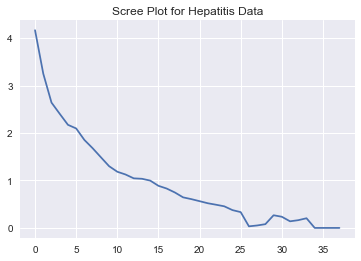

In [27]:
X_scaled = StandardScaler().fit_transform(X)
sklearn_pca = PCA()
sklearn_pca.fit(X_scaled)

print(
    'Percentage of total variance in dataset explained by each component:\n',
    sklearn_pca.explained_variance_ratio_
)

Xt = X_scaled.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title("Scree Plot for Hepatitis Data")
plt.show()

One common rule is to keep all components that have a covariance over 1. 

In [29]:
sklearn_pca = PCA(n_components = 12)
sklearn_pca.fit(X_scaled)
X_pca = sklearn_pca.transform(X_scaled)
X_pca_df = pd.DataFrame(data=X_pca)

In [30]:
run_logistic(X_pca_df, Y, 'l1')

C = 0.0001

    coefficients  columns  abs
0            0.0        0  0.0
1            0.0        1  0.0
2            0.0        2  0.0
3            0.0        3  0.0
4            0.0        4  0.0
5            0.0        5  0.0
6            0.0        6  0.0
7            0.0        7  0.0
8            0.0        8  0.0
9            0.0        9  0.0
10           0.0       10  0.0
11           0.0       11  0.0
{'Final Score': 0.15742599742599742, 'Training Score': 0.0, 'Testing Score': 0.0, 'Cross-Val Accuracy': 0.39356499356499353, 'Negative Accuracy': 1, 'Positive Accuracy': 0, 'alpha': 0.0001}
C = 0.001

    coefficients  columns  abs
0            0.0        0  0.0
1            0.0        1  0.0
2            0.0        2  0.0
3            0.0        3  0.0
4            0.0        4  0.0
5            0.0        5  0.0
6            0.0        6  0.0
7            0.0        7  0.0
8            0.0        8  0.0
9            0.0        9  0.0
10           0.0       10  0.0
11          

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pred

{'Final Score': 0.63958387431776953, 'Training Score': 0.67639224685889199, 'Testing Score': 0.65689976478959022, 'Cross-Val Accuracy': 0.61361003861003849, 'Negative Accuracy': 0.29999999999999999, 'Positive Accuracy': 0.85250737463126847, 'alpha': 0.1}
C = 0.3

    coefficients  columns       abs
1       0.434603        1  0.434603
4      -0.278945        4  0.278945
0       0.260348        0  0.260348
5       0.153025        5  0.153025
3      -0.121486        3  0.121486
8      -0.075687        8  0.075687
7       0.045514        7  0.045514
10     -0.017678       10  0.017678
2       0.017526        2  0.017526
9      -0.010207        9  0.010207
11      0.007922       11  0.007922
6       0.002659        6  0.002659
{'Final Score': 0.63886674786905451, 'Training Score': 0.67843938835753748, 'Testing Score': 0.66044500878218648, 'Cross-Val Accuracy': 0.6064993564993566, 'Negative Accuracy': 0.29999999999999999, 'Positive Accuracy': 0.84070796460176989, 'alpha': 0.3}
C = 0.5

    c

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 100}
C = 1000

    coefficients  columns       abs
1       0.485053        1  0.485053
4      -0.312059        4  0.312059
0       0.303203        0  0.303203
5       0.196322        5  0.196322
3      -0.144619        3  0.144619
8      -0.101367        8  0.101367
7       0.077253        7  0.077253
2       0.048716        2  0.048716
10     -0.046997       10  0.046997
9      -0.046044        9  0.046044
6       0.039879        6  0.039879
11      0.034712       11  0.034712
{'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 1000}
C = 100000.

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 1000000000.0}
Best Run: {'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 1000000000.0}


In [31]:
run_logistic(X_pca_df, Y, 'l2')

C = 0.0001

    coefficients  columns       abs
1       0.005424        1  0.005424
4      -0.003822        4  0.003822
0       0.003348        0  0.003348
3      -0.002021        3  0.002021
5       0.001956        5  0.001956
8      -0.001307        8  0.001307
7       0.000834        7  0.000834
10     -0.000538       10  0.000538
11      0.000476       11  0.000476
2       0.000457        2  0.000457
9      -0.000252        9  0.000252
6       0.000165        6  0.000165
{'Final Score': 0.62844657582192687, 'Training Score': 0.67562586466057817, 'Testing Score': 0.65137921367146556, 'Cross-Val Accuracy': 0.59404761904761905, 'Negative Accuracy': 0.30454545454545456, 'Positive Accuracy': 0.84660766961651912, 'alpha': 0.0001}
C = 0.001

    coefficients  columns       abs
1       0.048272        1  0.048272
4      -0.034013        4  0.034013
0       0.029794        0  0.029794
3      -0.017975        3  0.017975
5       0.017406        5  0.017406
8      -0.011627        8  0.011627

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.64737316270280409, 'Training Score': 0.67706171512657898, 'Testing Score': 0.66987118708725624, 'Cross-Val Accuracy': 0.6136261261261261, 'Negative Accuracy': 0.31818181818181818, 'Positive Accuracy': 0.84955752212389379, 'alpha': 0.1}
C = 0.3

    coefficients  columns       abs
1       0.465080        1  0.465080
4      -0.301767        4  0.301767
0       0.290403        0  0.290403
5       0.186380        5  0.186380
3      -0.141702        3  0.141702
8      -0.098531        8  0.098531
7       0.073644        7  0.073644
2       0.046326        2  0.046326
10     -0.045201       10  0.045201
9      -0.042076        9  0.042076
6       0.035986        6  0.035986
11      0.033972       11  0.033972
{'Final Score': 0.64815426316235203, 'Training Score': 0.67898661883216871, 'Testing Score': 0.67237422238770383, 'Cross-Val Accuracy': 0.61182432432432432, 'Negative Accuracy': 0.31818181818181818, 'Positive Accuracy': 0.84955752212389379, 'alpha': 0.3}
C = 0.5

    c

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 100}
C = 1000

    coefficients  columns       abs
1       0.485071        1  0.485071
4      -0.312067        4  0.312067
0       0.303214        0  0.303214
5       0.196336        5  0.196336
3      -0.144627        3  0.144627
8      -0.101376        8  0.101376
7       0.077260        7  0.077260
2       0.048728        2  0.048728
10     -0.047004       10  0.047004
9      -0.046060        9  0.046060
6       0.039889        6  0.039889
11      0.034719       11  0.034719
{'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 1000}
C = 100000.

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


{'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 1000000000.0}
Best Run: {'Final Score': 0.65235958038548159, 'Training Score': 0.67893783220108284, 'Testing Score': 0.67700213204530069, 'Cross-Val Accuracy': 0.61539575289575288, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84955752212389379, 'alpha': 1000000000.0}


In [32]:
run_tree(X_pca_df, Y)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
{'Final Score': 0.61250830708902282, 'Training Score': 0.67974906612326591, 'Testing Score': 0.63442504205956829, 'Cross-Val Accuracy': 0.57963320463320467, 'Negative Accuracy': 0.018181818181818181, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 4}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
{'Final Score': 0.61250830708902282, 'Training Score': 0.67974906612326591, 'Testing Score': 0.63442504205956829, 'Cross-Val Accuracy': 0.57963320463320467, 'Negative Accuracy': 0.018181818181818181, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 5}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
{'Final Score': 0.61250830708902282, 'Training Score': 0.67974906612326591, 'Testing Score': 0.63442504205956829, 'Cross-Val Accuracy': 0.57963320463320467, 'Negative Accuracy':

In [ ]:
run_forest(X_pca_df, Y)

Max Depth: 3, Max Feature = 4, Number of Trees = 10, Random State = 1, Min Samples Split: 4
{'Final Score': 0.6079088853228839, 'Training Score': 0.71566879137865891, 'Testing Score': 0.62916174151840587, 'Cross-Val Accuracy': 0.57602960102960099, 'Negative Accuracy': 0.23636363636363636, 'Positive Accuracy': 0.9528023598820059, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 10, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 50, Random State = 1, Min Samples Split: 4
{'Final Score': 0.62170494511993479, 'Training Score': 0.70201795441537729, 'Testing Score': 0.6354456078039239, 'Cross-Val Accuracy': 0.60109395109395103, 'Negative Accuracy': 0.27727272727272728, 'Positive Accuracy': 0.95870206489675514, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 50, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 100, Random State = 1, Min Samples Split: 4
{'Final Score': 0.62226472557338974, 'Tr

In [ ]:
run_svc(X_pca_df, Y)

Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.3
Gamma = 0.02857142857142857
Kernel:

In [ ]:
run_boosting(X_pca_df, Y)

# Analysis

# SVM

After running all the models, Support Vector Machine produced the best cross-val score of 68.08%. Support Vector machines are useful because they can handle a large feature space like this one with 31 features. They can also handle non-linear feature interactions, which is quite common in real world data, especially as you account for more features. By using a statistical technique called kernel smoothing, SVMs are able to reduce overfitting to nuanced datapoints and focus on the big picture.  SVMs are not ideal when the dataset has a vast number of observations, but that is not the case here as we only have 559 datapoints. Although the Gaussian kernel was responsible for the best score, the differences between the scores for linear and Gaussian kernels were negligible. Gaussian kernels require more resources to train (longer computing time, varied gamma parameter) with little to no gain in predictive performance in datasets that have many features. In the future, I would go with a linear kernel.

# Logistic Regression

Because of the computational simplicity of logistic regression, I tried this method first, using both ridge and lasso models for baseline scores to compare the later models. Both ridge and lasso models hovered around 66% with a reduced feature set. When using the full feature set, regularization was necessary to achieve higher scores, and ridge was slightly better than lasso. In this dataset, nuances in the data were causing the models to overfit, as seen by the difference in training/testing scores. Once the feature set was reduced by variable importance and PCA, regularization was not helpful. This may be because we eliminated many of the multicollinear features that were previously creating a need for regularization. In these reduced feature sets, lasso performed slightly better than ridge.<br>

In binary logistic regression, binary output data is converted to a probability distribution and transformed using the log function. The ideal scenario would see a linear relationship between the features and this new, transformed output data. If logistic regression is not performing well, it may be because the data did not fit a linear relationship, even after transformation. Linear relationships cannot be modeled when features have multicollinearity. When features are closely related to eachother, certain features get blown way out of proportion despite the model showing minimal error. This is when regularization helps (especially L2 regularization), as it supplements the traditional error function with a penalty for extreme parameter estimates. In both logistic models with full feature sets, regularization was moderately strong at 0.5, which shows that the features were collinear. They may not have been a good fit for logistic regression, even with the added power of regularization.<br>

When the models are re-run with reduced feature sets, the scores improve. Using a boosting model, we were able to eliminate features based on variable importance. Less important variables tended to be multicollinear with other variables, which is why eliminating them improved the score. This allowed these linear models to outperform most of the other models, but they are still not strong enough to stand on their own.

Logistic regression is also not ideal when the dataset has a large number of categorical features. Many of the features in this model were on a sliding scale, either binary 0/1 or 0-4. Although these features are not purely categorical, they are not true continuous variabales either which may have affected their cooperation with logistic regression models.

# Random Forest

Surprisingly, random forest scores were low across the board. Random forests typically make complex models that can work with complex feature relationships. However, random forest performed worse than logistic models, boosting, SVM, and singular decision trees. At the very least, I expected random forest to perform better than one decision tree, but this was only the case in the full feature set. Ensemble models are not always better than their single counterparts; they only better if the single models suffer of instability. The decision trees were also significantly less prone to overfitting than the full forests.

Both trees and forests were less effective than the baseline logistic regression models. Interestingly, the random forest using the full feature set outperformed the lasso regression model, but the random forest using the reduced feature set did not. This is surprising given that trees/forests should work well when output classes are balanced and when the models are not expected to predict far beyond the training range. Trees and forests are typically better at representing complex, non-linear relationships than logistic models because they do not rely on linear decision boundaries, rather they partition the space into smaller linear decision boundaries and combine them. However, their complexity also makes them prone to overfitting. We can see here that these models are indeed overfitting, but they are not accurately representing the complex feature relationships. This may because I didn't tune the parameters correctly. Features that I neglected to tune in this project were min_samples_leaf, max_leaf_nodes, and min_weight_fraction_leaf. In the future, I would experiment with these. Another problem I can see is that I was unable to use the pruning method on my trees, which helps combat overfitting but is currently unsupported by SKLearn. Additionally, random forests are not good with large numbers of categorical variables.

# Boosting Model

Surprisingly, the boosting models gave the lowest score of all the models. This is uncommon with ensemble models Looking at all the models, there was often a very large gap between the training and testing scores, which means that these models were drastically overfitting. Gradient boosting models are notoriously prone to overfitting (especially with high number of trees), but this should be combated by using a small learning rate. A small learning rate means the model is weighting the earlier models more, and the later models (built off the residuals) have a smaller effect on the outcome.

# Conclusion

Overall, these results are not impressive. Although the data is non-linear, it is being represented best by linear models (logistic, SVM with linear kernel). However, these models are not adequately capturing the complexity of the non-linear relationships as demonstrated by their low scores. This means that the models are underfitting. The highest score of any model was 68.08%, achieved through SVM with a linear kernel and 5-fold cross validation. This model has the highest predictive power, but lower explanatory power than a model derived from logistic regression. Using ridge regression without regularization, a score of 65.26% was achieved. Compared to the original study's final AUC of 62%, both of these are comparable but not accurate enough to stand on their own.<br>

The non-linear models (decision tree, random forest, gradient boosting) performed even worse than the linear models. This could be because I am either not tuning the parameters correctly or not using the best parameters. These techniques were majorly prone to overfitting, seeing training score/testing score differences as high as 15%. In 2/3 iterations, decision trees outperformed random forest, and in 3/3 iterations, decision trees outperformed gradient boosting. This is suprising given that both random forest and gradient boosting are ensemble models built off decision trees. Ensemble models tend to perform better than their singular components, but only under the assumption that the decision tree component is a weak learner. If the decision tree is stable, it is perfectly fine functioning on its own.

# Future Suggestions

It is clear that the features available to us are not sufficient for predicting the prognosis of patients with NSCLC. We have tried several different types of linear and non-linear machine learning algorithms and have reached a maximum of 68% (with preference to predicting deaths accurately).

It is impossible to make a good model with bad data, and this may be the case here. This data has several subjective categorical features, such as level of dyspnea and esophageal toxicity that could range depending on the perspective of the attending doctor or the patient. Dyspnea and esophageal toxicity before and after treatment are great markers of disease burden, but their scoring system is not allowing them to be utilized in a useful way.

Although I did some preliminary cleaning and elimination of features, in the future I would experiment more with manipulating these features. For example, I converted all categorical features to dummy features, but in the future I could try removing them altogether. Another measure I took was to fill in all missing values with the mean for that feature (for features with over 50% values) but in the future I could raise this threshold or drop those values entirely. I could also add code that eliminates features based on their correlation with other features, to make sure that multicollinear features are not complicating my linear models.

I would also investigate further into my random forest and gradient boosting models, two ensemble models that are known to work well for classifying data. Though I tried a variety of parameters that warranted significant computation time, in the future I could try more parameters and try to get into the details of why they weren't performing well. Additionally, I would love to get access to another dataset for external validation.

Lastly, I would try to get the research group to re-define the evaluation criteria. Less categorical variables and more lab results, with commonly accepted prognostic markers such as immunohistochemistry results that give a continuous/numeric representation of disease burden. Microarrays showing mRNA expression of gene sequences could be another cost-effective technique for measuring disease burden. Whether or not the Maastro clinic is a research hospital, if they desire valid results for a research study, they could collaborate with a nearby lab to produce better medical data. This would produce better models that would benefit their future patients as well as NSCLC patients all around the world.